# CFO Forecasting - Financial Forecast BB Sandesh Brand 4 - Refinement

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from collections import Counter
from sklearn.metrics import mean_squared_error, r2_score
import datetime
import gc
import os
import lightgbm as lgb
import xgboost as xgb
print ("lightgbm.__version__ =", lgb.__version__) # LightGBM version = 2.3.1
print ("xgboost.__version__ =", xgb.__version__)  # xgboost version = 1.1.1

lightgbm.__version__ = 2.3.1
xgboost.__version__ = 1.1.1


## Data Loading (seperate data into train and test dataframe)

In [2]:
data_file = "./Privatized Data for Evaluation.xlsx"
start_date_train = '2016-04-01'
challenge_targets = ['Falcon_ARPNU', 'Falcon_ARPEU', 'Falcon_Gross', 'Falcon_Migrate']
print(f"data_file = {data_file}, start_date_train = {start_date_train}")
print(f"challenge_targets = {challenge_targets}")
# objective forecasting from Oct-19 to Mar-20: input parameters = (Oct-19, Sep-20, 12, 0)
# robustness calculation from Apr-19 to Mar-20: input parameters = (Apr-19, Mar-20, 12, 1)
# robustness calculation from Mar-19 to Feb-20: input parameters = (Mar-19, Feb-20, 12, 2)
# robustness calculation from Feb-19 to Jan-20: input parameters = (Feb-19, Jan-20, 12, 3)
# robustness calculation from Jan-19 to Dec-19: input parameters = (Jan-19, Dec-19, 12, 4)
# robustness calculation from Dec-18 to Nov-19: input parameters = (Dec-18, Nov-19, 12, 5)
# robustness calculation from Nov-18 to Oct-19: input parameters = (Nov-18, Oct-19, 12, 6)

def data_loading(start_date, end_date, forecasting_months, iteration):
    input_df = pd.read_excel(data_file)
    cols = input_df.columns.tolist()
    header_cols = 9
    target_var = ['Tortoise_ARPEU', 'Tortoise_ARPNU', 'Tortoise_Revenue', 'Tortoise_NetAdds', 'Tortoise_Opening',
                  'Tortoise_Closing', 'Falcon_ARPNU', 'Falcon_ARPEU', 'Falcon_Closing', 'Falcon_Revenue',
                  'Falcon_NetAdds', 'Falcon_Opening', 'Tortoise_Gross', 'Falcon_Gross', 'Tortoise_Migrate', 
                  'Falcon_Migrate', 'Tortoise_Leavers', 'Falcon_Churn'] 
    month_to_date = {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06',
                     'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'} 
    
    if iteration == 0:  # objective forecasting
        # select training columns and set train_months
        test_months = 6
        train_cols = [cols[7]] + cols[header_cols:-test_months]
        train_months = len(cols) - header_cols - test_months
        # select test columns and set test_months
        start_month, end_month = month_to_date[start_date[:3]], month_to_date[end_date[:3]]
        start_year, end_year = start_date[-2:], end_date[-2:]
        start_date_test = f"20{start_year}-{start_month}-01"
        end_date_test = f"20{end_year}-{end_month}-01"
        test_cols = [cols[7]] + cols[-test_months:]
                
        
    else:  # robustness calculation
        # select training columns and set train_months
        last_col = forecasting_months + iteration - 1
        train_cols = [cols[7]] + cols[header_cols:-last_col]  # select columns            
        train_months = len(cols) - header_cols - last_col
        
        # select test columns and set test_months
        start_month, end_month = month_to_date[start_date[:3]], month_to_date[end_date[:3]]
        start_year, end_year = start_date[-2:], end_date[-2:]
        start_date_test = f"20{start_year}-{start_month}-01"
        end_date_test = f"20{end_year}-{end_month}-01"
        test_months = forecasting_months 
        if iteration == 1:
            test_cols = [cols[7]] + cols[-forecasting_months:]  # select columns
        else:
            first_col = -forecasting_months - iteration + 1
            test_cols = [cols[7]] + cols[first_col: -iteration + 1]  # select columns                        
            
    # get train_df
    train_df = input_df.loc[2:, train_cols].reset_index(drop=True)  # select rows
    train_dates = pd.date_range(start=start_date_train, periods=train_months, freq='MS').astype(str).tolist()
    train_df.columns = ['LookupKey'] + train_dates
    LookupKey = train_df['LookupKey'].values.tolist()   
    train_df['LookupKey'] = target_var
    
    # get test_df
    test_df = input_df.loc[2:, test_cols].reset_index(drop=True)  # select rows
    test_dates = pd.date_range(start=start_date_test, periods=test_months, freq='MS').astype(str).tolist()
    test_df.columns = ['LookupKey'] + test_dates
    test_df['LookupKey'] = target_var
    test_df = test_df.loc[test_df['LookupKey'].isin(challenge_targets)]
    end_date_train = train_dates[-1]
    
    print (f"iteration={iteration}, train_df: start={start_date_train}, end={end_date_train}, "
           f"#months={train_months}, forecasting_months={forecasting_months}, shape:{train_df.shape}")
    print (f"iteration={iteration},  test_df: start={start_date_test}, end={end_date_test}, "
           f"#months={test_months:>2}, forecasting_months={forecasting_months}, shape:{test_df.shape}")
    
    return train_df, test_df, LookupKey, target_var

data_file = ./Privatized Data for Evaluation.xlsx, start_date_train = 2016-04-01
challenge_targets = ['Falcon_ARPNU', 'Falcon_ARPEU', 'Falcon_Gross', 'Falcon_Migrate']


In [3]:
train_df, test_df, LookupKey, target_var = data_loading('Oct-19', 'Sep-20', 12, 0)
train_df

iteration=0, train_df: start=2016-04-01, end=2019-09-01, #months=42, forecasting_months=12, shape:(18, 43)
iteration=0,  test_df: start=2019-10-01, end=2020-09-01, #months= 6, forecasting_months=12, shape:(4, 7)


,LookupKey,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,2016-10-01,2016-11-01,2016-12-01,...,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01
0,Tortoise_ARPEU,-1.65976,-0.43167,-1.66854,-0.796268,-1.27381,-0.367703,0.454823,-0.367489,0.535663,...,0.412986,0.178859,0.148808,1.31372,0.464565,0.399726,0.461877,0.587363,0.00633797,-0.179016
1,Tortoise_ARPNU,-0.501863,0.228315,0.218987,0.394557,0.491434,0.355978,0.530223,0.583397,0.598761,...,-1.40066,-0.381748,0.303771,-0.341833,-0.055072,-0.498221,-0.836324,-0.437078,-0.82395,-1.34276
2,Tortoise_Revenue,1.27157,1.55807,1.15176,1.3497,1.16391,1.35839,1.54649,1.2652,1.38154,...,-0.572273,-0.654621,-0.708137,-0.589822,-0.783104,-0.85742,-0.905089,-0.957934,-1.11059,-1.20598
3,Tortoise_NetAdds,-0.490581,-0.500634,1.22578,0.456727,0.929976,0.195207,1.11364,0.937105,-2.32596,...,0.956003,1.24808,1.00613,0.135683,0.767813,0.432623,0.695049,0.149715,0.300449,0.178798
4,Tortoise_Opening,1.72732,1.64353,1.5595,1.51815,1.45778,1.40912,1.34229,1.29816,1.24967,...,-0.659815,-0.707836,-0.748635,-0.795416,-0.863719,-0.916392,-0.977353,-1.03183,-1.09978,-1.16401
5,Tortoise_Closing,1.72066,1.63636,1.59487,1.53432,1.4855,1.41845,1.37419,1.32555,1.19597,...,-0.638207,-0.679136,-0.726067,-0.794587,-0.847429,-0.908584,-0.96323,-1.0314,-1.09584,-1.16329
6,Falcon_ARPNU,0.10712,0.0753905,0.271979,0.505065,0.277726,0.349048,0.256174,-0.0106385,-0.139911,...,-0.110657,0.736367,0.99171,-0.0192782,0.295286,-0.748565,-1.44652,-1.05876,-1.37227,-1.71576
7,Falcon_ARPEU,-0.728341,0.189526,-0.376269,-0.605243,-0.629582,-1.16037,0.296251,0.955728,0.711331,...,1.73627,1.30873,1.61666,2.55431,1.1274,1.13188,1.09911,1.01635,0.551219,0.0993097
8,Falcon_Closing,-2.07084,-1.94445,-1.86147,-1.75038,-1.66754,-1.54102,-1.45418,-1.35278,-1.12104,...,0.580267,0.588449,0.624317,0.660281,0.69501,0.747883,0.813776,0.854716,0.931173,1.03837
9,Falcon_Revenue,-2.04873,-1.79448,-1.80392,-1.73784,-1.66609,-1.6384,-1.31554,-1.1066,-0.926608,...,0.945564,0.852335,0.960776,1.22085,0.912907,0.965374,1.0214,1.04079,0.999182,0.98731


In [4]:
test_df

,LookupKey,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01
6,Falcon_ARPNU,-1.65166,-1.44252,-1.75421,-1.34523,-1.67176,-1.97697
7,Falcon_ARPEU,0.0091798,0.0338353,-0.22804,-0.519837,-1.40362,-1.88329
13,Falcon_Gross,1.23378,1.70277,0.0878356,1.38314,0.215232,1.64326
15,Falcon_Migrate,1.80658,1.74941,1.27133,2.43961,1.65914,1.65092


In [5]:
# prepare training and test data for Robustness modeling and calculation 
robustness_list = [[1, 'Apr-19', 'Mar-20', 12], [2, 'Mar-19', 'Feb-20', 12], [3, 'Feb-19', 'Jan-20', 12],
                   [4, 'Jan-19', 'Dec-19', 12], [5, 'Dec-18', 'Nov-19', 12], [6, 'Nov-18', 'Oct-19', 12]]
for robust_i in range(len(robustness_list)):
    iteration = robustness_list[robust_i][0]
    start_date = robustness_list[robust_i][1]
    end_date = robustness_list[robust_i][2]
    forecasting_months = robustness_list[robust_i][3]    
    train_i, test_i, _, _ = data_loading(start_date, end_date, forecasting_months, iteration)
    print("")

iteration=1, train_df: start=2016-04-01, end=2019-03-01, #months=36, forecasting_months=12, shape:(18, 37)
iteration=1,  test_df: start=2019-04-01, end=2020-03-01, #months=12, forecasting_months=12, shape:(4, 13)

iteration=2, train_df: start=2016-04-01, end=2019-02-01, #months=35, forecasting_months=12, shape:(18, 36)
iteration=2,  test_df: start=2019-03-01, end=2020-02-01, #months=12, forecasting_months=12, shape:(4, 13)

iteration=3, train_df: start=2016-04-01, end=2019-01-01, #months=34, forecasting_months=12, shape:(18, 35)
iteration=3,  test_df: start=2019-02-01, end=2020-01-01, #months=12, forecasting_months=12, shape:(4, 13)

iteration=4, train_df: start=2016-04-01, end=2018-12-01, #months=33, forecasting_months=12, shape:(18, 34)
iteration=4,  test_df: start=2019-01-01, end=2019-12-01, #months=12, forecasting_months=12, shape:(4, 13)

iteration=5, train_df: start=2016-04-01, end=2018-11-01, #months=32, forecasting_months=12, shape:(18, 33)
iteration=5,  test_df: start=2018-12-

In [6]:
# Display target_var vs. LookupKey
for i in range(len(target_var)):
    print(f"{i:>2}, {target_var[i]:<16} -> {'-'.join(LookupKey[i].split('-')[1:])}")
print("")
print(f"#target_var = {len(target_var)}: {target_var}")

 0, Tortoise_ARPEU   ->  Segment 2BroadbandTortoiseAverage revenue per existing customer - Tortoise
 1, Tortoise_ARPNU   ->  Segment 2BroadbandTortoiseAverage revenue per new customer - Tortoise
 2, Tortoise_Revenue ->  Segment 2BroadbandTortoiseRevenue - Tortoise
 3, Tortoise_NetAdds ->  Segment 2BroadbandTortoiseNet Adds - Tortoise
 4, Tortoise_Opening ->  Segment 2BroadbandTortoiseOpening Base - Tortoise
 5, Tortoise_Closing ->  Segment 2BroadbandTortoiseClosing Base - Tortoise
 6, Falcon_ARPNU     ->  Segment 2BroadbandFalconAverage revenue per new customer - Falcon
 7, Falcon_ARPEU     ->  Segment 2BroadbandFalconAverage revenue per existing customer - Falcon
 8, Falcon_Closing   ->  Segment 2BroadbandFalconClosing Base - Falcon
 9, Falcon_Revenue   ->  Segment 2BroadbandFalconRevenue - Falcon
10, Falcon_NetAdds   ->  Segment 2BroadbandFalconNet Adds - Falcon
11, Falcon_Opening   ->  Segment 2BroadbandFalconOpening Base - Falcon
12, Tortoise_Gross   ->  Segment 2BroadbandTortoiseG

In [7]:
def preprocessing(df):
    df = df.transpose() # Transpose
    df.columns = df.loc['LookupKey'] # Set generic lookupkey as the new column name
    df = df.iloc[1:] # Drop extra rows so that the row starts with data variables
    df = df.rename_axis('Timestamp').reset_index() # Rename row index as 'Timestamp' 
    df.columns.name = None # Remove column name 'LookupKey'
    float_cols = df.columns.tolist()[1:]
    df[float_cols] = df[float_cols].astype(float) 
    return df

In [8]:
train_df = preprocessing(train_df)  # training data (Apr16 - Sep19)
train_df

,Timestamp,Tortoise_ARPEU,Tortoise_ARPNU,Tortoise_Revenue,Tortoise_NetAdds,Tortoise_Opening,Tortoise_Closing,Falcon_ARPNU,Falcon_ARPEU,Falcon_Closing,Falcon_Revenue,Falcon_NetAdds,Falcon_Opening,Tortoise_Gross,Falcon_Gross,Tortoise_Migrate,Falcon_Migrate,Tortoise_Leavers,Falcon_Churn
0,2016-04-01,-1.659763,-0.501863,1.271568,-0.490581,1.727318,1.720659,0.107120,-0.728341,-2.070840,-2.048733,1.821946,-2.109684,2.074017,-1.557326,0.797394,-1.328065,1.586660,-1.321347
1,2016-05-01,-0.431670,0.228315,1.558066,-0.500634,1.643531,1.636355,0.075391,0.189526,-1.944454,-1.794477,0.974564,-1.946444,1.695281,-1.845046,1.642957,-1.328528,1.080402,-1.595363
2,2016-06-01,-1.668541,0.218987,1.151760,1.225784,1.559496,1.594873,0.271979,-0.376269,-1.861468,-1.803917,0.068818,-1.822896,2.104731,-1.434703,1.973199,-1.244046,1.068644,-1.488426
3,2016-07-01,-0.796268,0.394557,1.349704,0.456727,1.518146,1.534315,0.505065,-0.605243,-1.750378,-1.737836,0.655341,-1.741774,2.078481,-0.757287,0.695673,-0.822560,1.199660,-1.289174
4,2016-08-01,-1.273815,0.491434,1.163915,0.929976,1.457781,1.485496,0.277726,-0.629582,-1.667544,-1.666090,0.065645,-1.633178,1.630765,-1.206455,1.220882,-0.779971,1.042609,-1.264496
5,2016-09-01,-0.367703,0.355978,1.358386,0.195207,1.409116,1.418452,0.349048,-1.160367,-1.541025,-1.638399,0.977352,-1.552204,1.877684,-0.717324,1.813199,-0.686462,1.121051,-1.088095
6,2016-10-01,0.454823,0.530223,1.546490,1.113640,1.342285,1.374188,0.256174,0.296251,-1.454178,-1.315544,0.149393,-1.428525,1.785791,-0.715757,0.147152,-0.687967,0.925031,-1.182237
7,2016-11-01,-0.367489,0.583397,1.265202,0.937105,1.298162,1.325546,-0.010638,0.955728,-1.352777,-1.106601,0.453135,-1.343629,1.644050,0.525412,0.147152,-0.634153,1.302121,-1.207828
8,2016-12-01,0.535663,0.598761,1.381537,-2.325956,1.249675,1.195968,-0.139911,0.711331,-1.121037,-0.926608,3.173257,-1.244504,0.959838,-0.245483,0.090993,-0.925790,0.240895,-1.372531
9,2017-01-01,0.003449,0.592475,1.172018,0.366083,1.120509,1.133162,-0.088569,-0.509628,-1.023373,-1.056253,0.375156,-1.017968,0.482177,-0.950544,0.572759,-0.444357,0.213684,-1.525900


In [9]:
test_df = preprocessing(test_df)  # test data (Oct19 - March20)
test_df

,Timestamp,Falcon_ARPNU,Falcon_ARPEU,Falcon_Gross,Falcon_Migrate
0,2019-10-01,-1.651663,0.009180,1.233778,1.806576
1,2019-11-01,-1.442524,0.033835,1.702771,1.749406
2,2019-12-01,-1.754209,-0.228040,0.087836,1.271329
3,2020-01-01,-1.345226,-0.519837,1.383145,2.439615
4,2020-02-01,-1.671763,-1.403620,0.215232,1.659137
5,2020-03-01,-1.976966,-1.883290,1.643264,1.650920


## Data Analysis and Feature Engineering

In [10]:
# Use different targets of the same Timestamp for regression (only in training data)
# These additional data samples will reduce the impact of 'step change outlier'
def train_target_regr(df, regr_var):
    regr_df = df[['Timestamp']].copy()
    for i in range(len(regr_var)):
        target = regr_var[i]
        features = [c for c in target_var if c != target]
        regr = Ridge(alpha=0.1, random_state=0) # alpha=2.0, 1.0, 0.1, 0.01
        regr.fit(df[features], df[target])            
        regr_df[target] = regr.predict(df[features])
        # regr_df[target+'_err'] = np.abs(regr_df[target] - train_df[target])
        score = r2_score(df[target], regr_df[target])
        df_shape = df[features].shape
        print(f"i={i}, target={target:<15}, training feature shape:{df_shape}, score={score:.6f}")
    return regr_df

In [11]:
regr_var = ['Falcon_ARPNU', 'Falcon_ARPEU']
print(f"regr_var = {regr_var}\n")
regr_df = train_target_regr(train_df, regr_var)
regr_df

regr_var = ['Falcon_ARPNU', 'Falcon_ARPEU']

i=0, target=Falcon_ARPNU   , training feature shape:(42, 17), score=0.743802
i=1, target=Falcon_ARPEU   , training feature shape:(42, 17), score=0.981836


,Timestamp,Falcon_ARPNU,Falcon_ARPEU
0,2016-04-01,-0.093941,-0.724246
1,2016-05-01,0.396554,-0.009156
2,2016-06-01,0.321902,-0.299257
3,2016-07-01,0.353925,-0.505794
4,2016-08-01,0.477950,-0.543312
5,2016-09-01,0.027899,-0.868226
6,2016-10-01,0.470649,0.131870
7,2016-11-01,0.121768,0.516662
8,2016-12-01,0.280250,0.466718
9,2017-01-01,0.289617,-0.441624


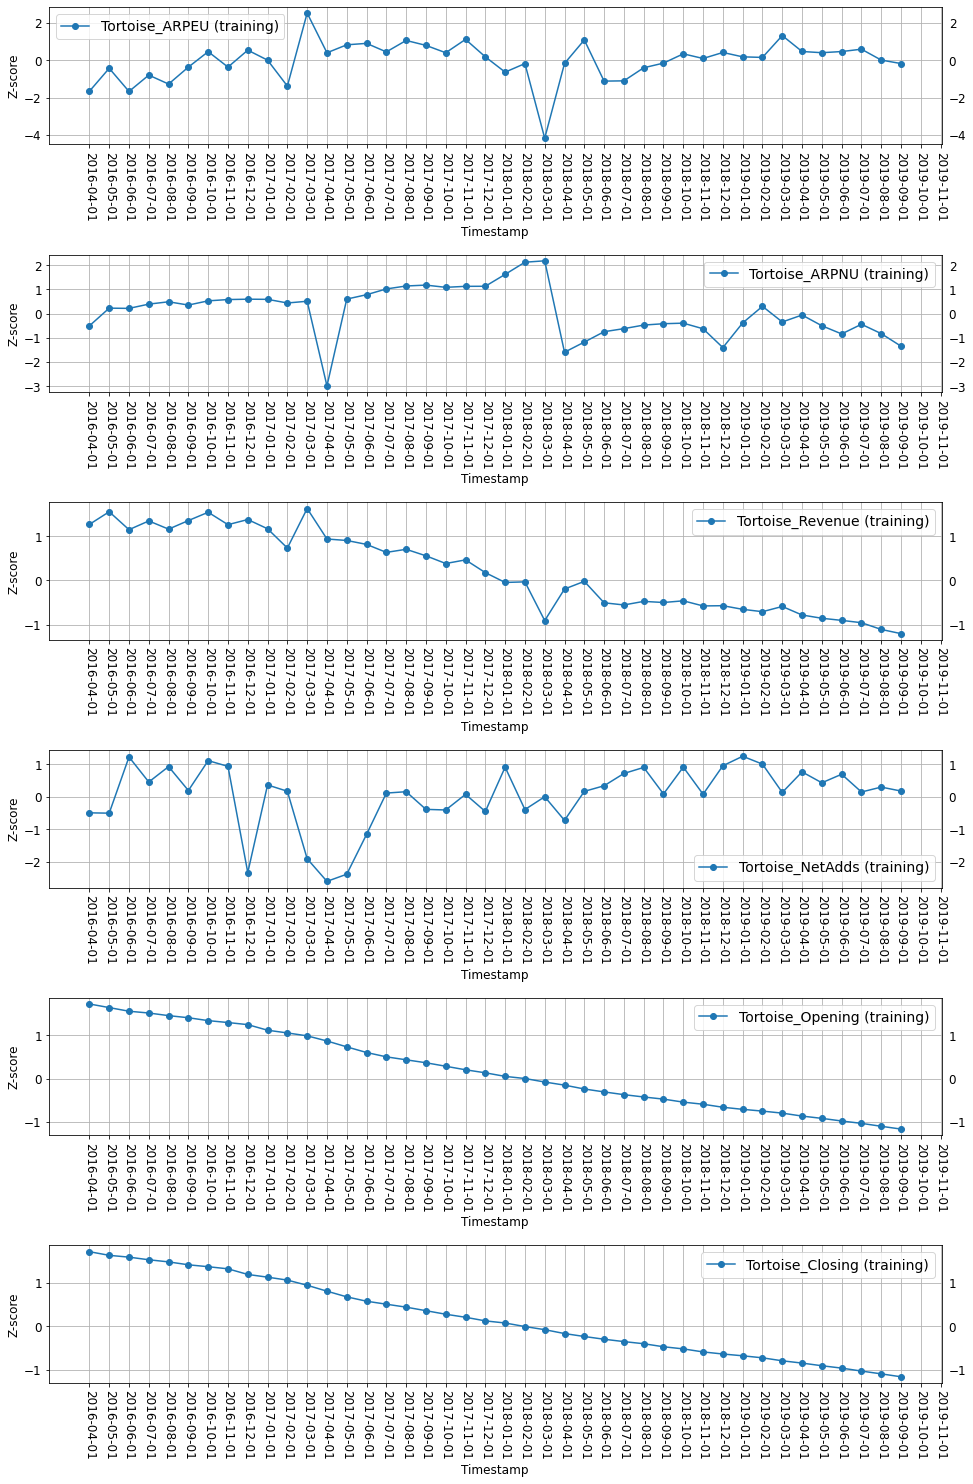

In [12]:
# Plot time series of first 6 targets
plt.figure(figsize=(16,80))
# add null test data to train data to plot 
test_null = test_df.copy()
test_null[challenge_targets] = np.nan
train_plot = pd.concat([train_df, test_null], ignore_index=True)
for i in range(0, 6):
    plt.subplot(len(target_var), 1, i+1)
    plt.plot(train_plot['Timestamp'], train_plot[target_var[i]], 'o-', label=target_var[i] + " (training)")
    if target_var[i] in challenge_targets:
        plt.plot(test_df['Timestamp'], test_df[target_var[i]], 'x-', label=target_var[i] + " (test)")
    if target_var[i] in regr_var:
        plt.plot(regr_df['Timestamp'], regr_df[target_var[i]], '--', label=target_var[i] + " (regression)")
    plt.tick_params(labelright=True)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12, rotation=270)
    plt.yticks(fontsize=12)
    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel("Z-score", fontsize=12)
    plt.grid(True)
plt.subplots_adjust(hspace=0.8)
plt.show()

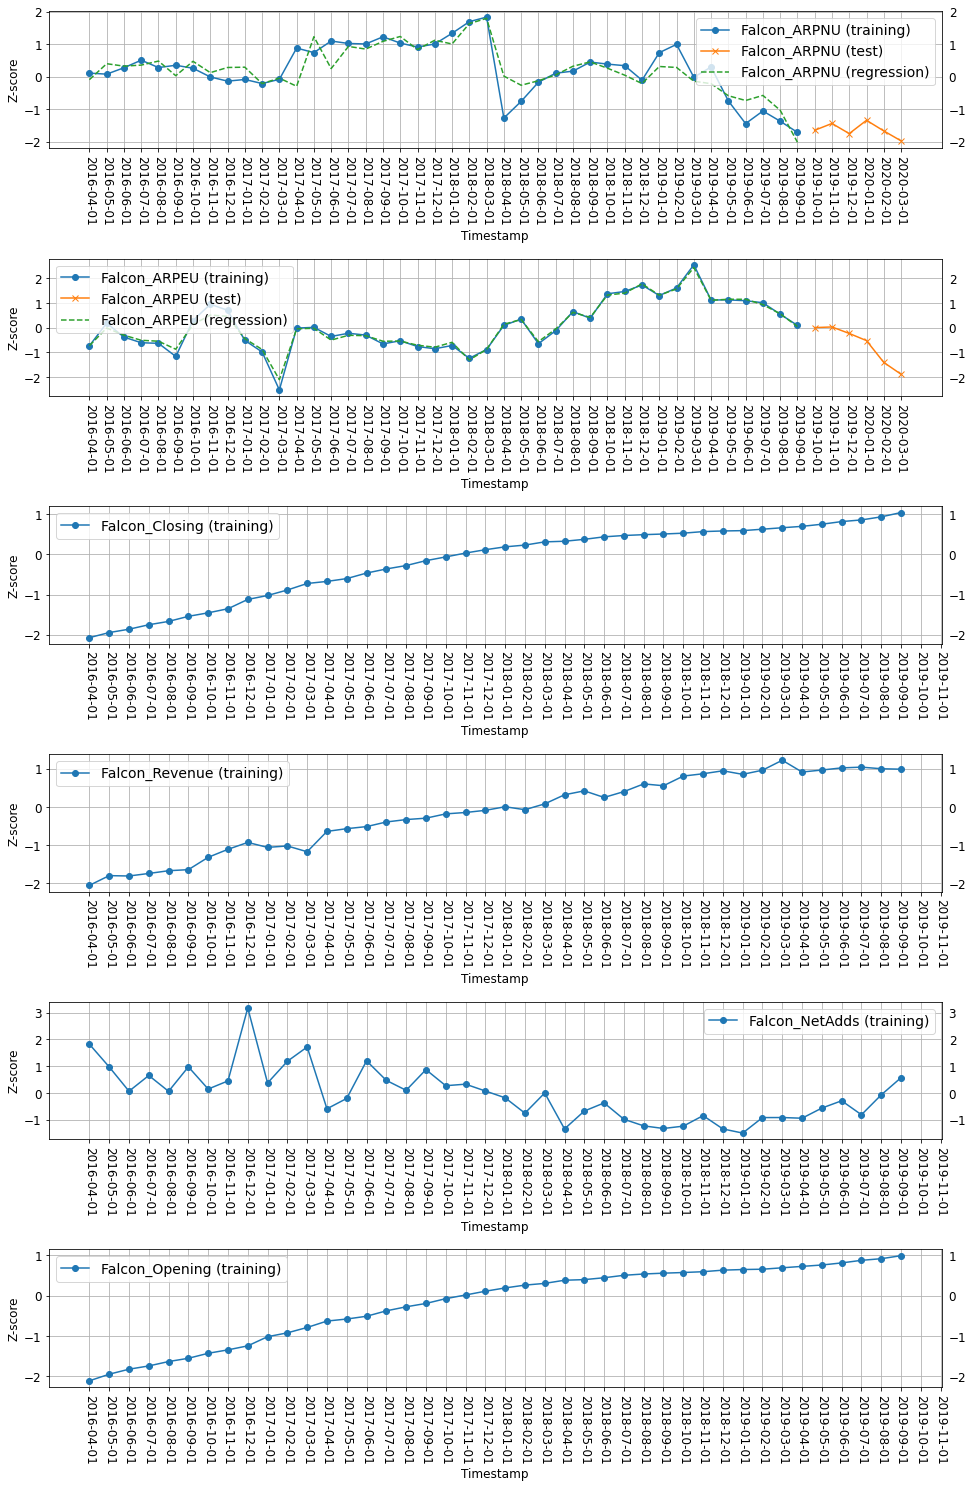

In [13]:
# Plot time series of next 6 targets
plt.figure(figsize=(16,80))
for i in range(6, 12):
    plt.subplot(len(target_var), 1, i+1)
    plt.plot(train_plot['Timestamp'], train_plot[target_var[i]], 'o-', label=target_var[i] + " (training)")
    if target_var[i] in challenge_targets:
        plt.plot(test_df['Timestamp'], test_df[target_var[i]], 'x-', label=target_var[i] + " (test)")
    if target_var[i] in regr_var:
        plt.plot(regr_df['Timestamp'], regr_df[target_var[i]], '--', label=target_var[i] + " (regression)")
    plt.tick_params(labelright=True)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12, rotation=270)
    plt.yticks(fontsize=12)
    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel("Z-score", fontsize=12)
    plt.grid(True)
plt.subplots_adjust(hspace=0.8)
plt.show()

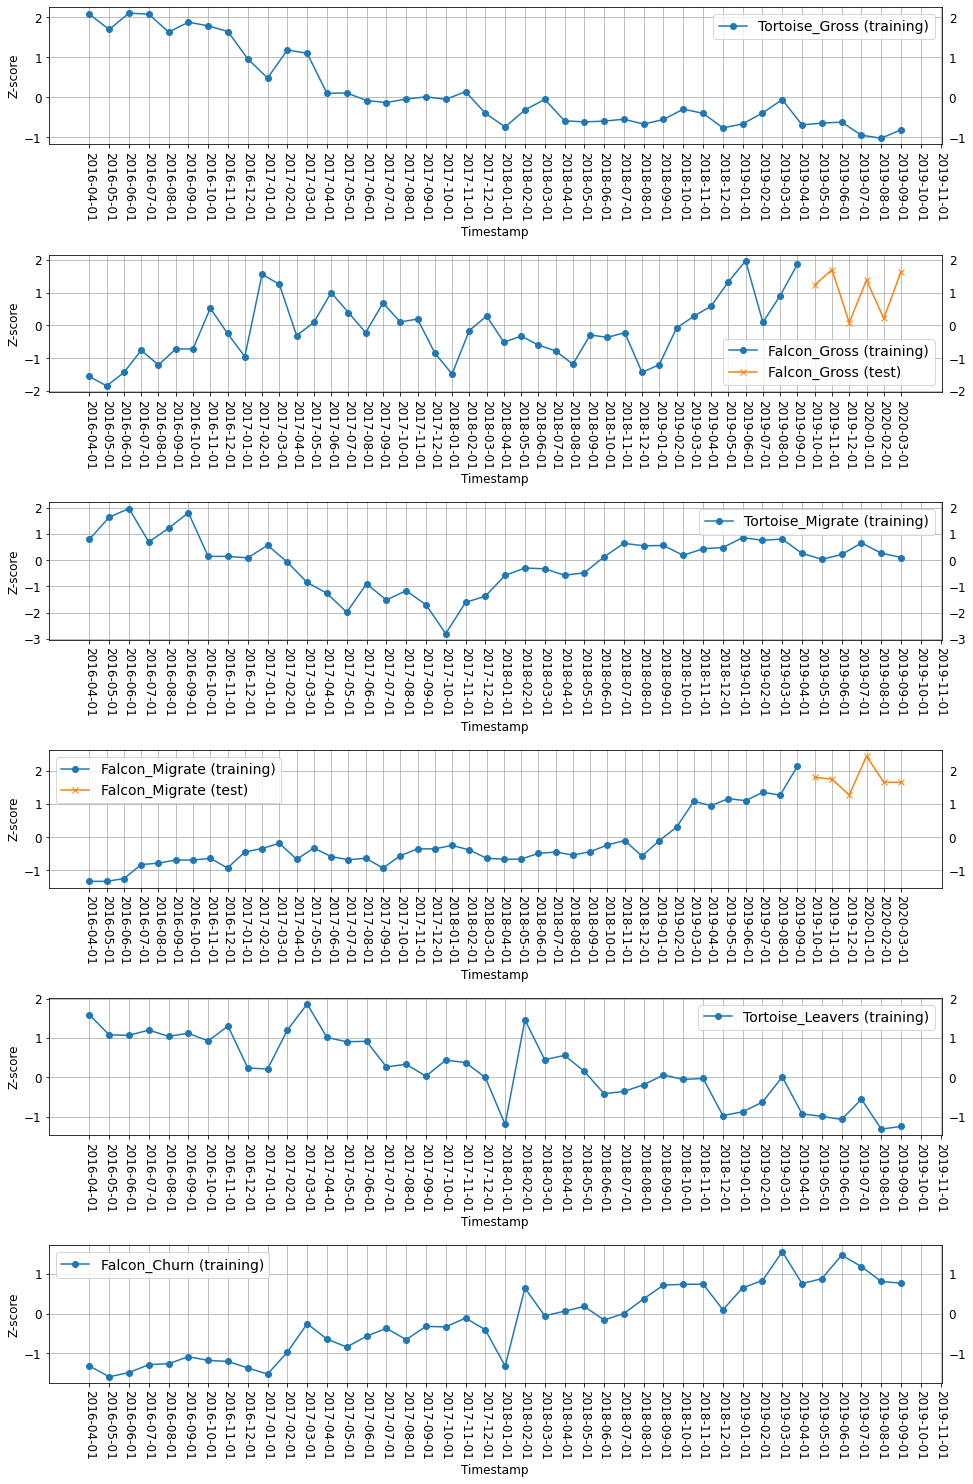

In [14]:
# Plot time series of last 6 targets
plt.figure(figsize=(16,80))
for i in range(12, len(target_var)):
    plt.subplot(len(target_var), 1, i+1)
    plt.plot(train_plot['Timestamp'], train_plot[target_var[i]], 'o-', label=target_var[i] + " (training)")
    if target_var[i] in challenge_targets:
        plt.plot(test_df['Timestamp'], test_df[target_var[i]], 'x-', label=target_var[i] + " (test)")
    if target_var[i] in regr_var:
        plt.plot(regr_df['Timestamp'], regr_df[target_var[i]], '--', label=target_var[i] + " (regression)")
    plt.tick_params(labelright=True)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=12, rotation=270)
    plt.yticks(fontsize=12)
    plt.xlabel("Timestamp", fontsize=12)
    plt.ylabel("Z-score", fontsize=12)
    plt.grid(True)
plt.subplots_adjust(hspace=0.8)
plt.show()

In [15]:
print("Replace original values by its average with regression results (only in training data)")
for var in regr_var:
    train_df[var] = 0.5*train_df[var] + 0.5*regr_df[var]
    print(f"get average with regression to replace {var}")
train_df

Replace original values by its average with regression results (only in training data)
get average with regression to replace Falcon_ARPNU
get average with regression to replace Falcon_ARPEU


,Timestamp,Tortoise_ARPEU,Tortoise_ARPNU,Tortoise_Revenue,Tortoise_NetAdds,Tortoise_Opening,Tortoise_Closing,Falcon_ARPNU,Falcon_ARPEU,Falcon_Closing,Falcon_Revenue,Falcon_NetAdds,Falcon_Opening,Tortoise_Gross,Falcon_Gross,Tortoise_Migrate,Falcon_Migrate,Tortoise_Leavers,Falcon_Churn
0,2016-04-01,-1.659763,-0.501863,1.271568,-0.490581,1.727318,1.720659,0.006589,-0.726293,-2.070840,-2.048733,1.821946,-2.109684,2.074017,-1.557326,0.797394,-1.328065,1.586660,-1.321347
1,2016-05-01,-0.431670,0.228315,1.558066,-0.500634,1.643531,1.636355,0.235972,0.090185,-1.944454,-1.794477,0.974564,-1.946444,1.695281,-1.845046,1.642957,-1.328528,1.080402,-1.595363
2,2016-06-01,-1.668541,0.218987,1.151760,1.225784,1.559496,1.594873,0.296940,-0.337763,-1.861468,-1.803917,0.068818,-1.822896,2.104731,-1.434703,1.973199,-1.244046,1.068644,-1.488426
3,2016-07-01,-0.796268,0.394557,1.349704,0.456727,1.518146,1.534315,0.429495,-0.555518,-1.750378,-1.737836,0.655341,-1.741774,2.078481,-0.757287,0.695673,-0.822560,1.199660,-1.289174
4,2016-08-01,-1.273815,0.491434,1.163915,0.929976,1.457781,1.485496,0.377838,-0.586447,-1.667544,-1.666090,0.065645,-1.633178,1.630765,-1.206455,1.220882,-0.779971,1.042609,-1.264496
5,2016-09-01,-0.367703,0.355978,1.358386,0.195207,1.409116,1.418452,0.188474,-1.014296,-1.541025,-1.638399,0.977352,-1.552204,1.877684,-0.717324,1.813199,-0.686462,1.121051,-1.088095
6,2016-10-01,0.454823,0.530223,1.546490,1.113640,1.342285,1.374188,0.363411,0.214060,-1.454178,-1.315544,0.149393,-1.428525,1.785791,-0.715757,0.147152,-0.687967,0.925031,-1.182237
7,2016-11-01,-0.367489,0.583397,1.265202,0.937105,1.298162,1.325546,0.055565,0.736195,-1.352777,-1.106601,0.453135,-1.343629,1.644050,0.525412,0.147152,-0.634153,1.302121,-1.207828
8,2016-12-01,0.535663,0.598761,1.381537,-2.325956,1.249675,1.195968,0.070169,0.589025,-1.121037,-0.926608,3.173257,-1.244504,0.959838,-0.245483,0.090993,-0.925790,0.240895,-1.372531
9,2017-01-01,0.003449,0.592475,1.172018,0.366083,1.120509,1.133162,0.100524,-0.475626,-1.023373,-1.056253,0.375156,-1.017968,0.482177,-0.950544,0.572759,-0.444357,0.213684,-1.525900


In [16]:
# add inverse samples as additional data (only in training data)
def get_inverse_corr(df):
    for i in range(len(target_var)):
        c = target_var[i]
        df[c+'_inv'] = -1 * df[c]
        
    # compute pairwise correlation of different variables of training data
    df_corr = df.corr()
    
    return df, df_corr

In [17]:
train_df, train_corr = get_inverse_corr(train_df)
train_df

,Timestamp,Tortoise_ARPEU,Tortoise_ARPNU,Tortoise_Revenue,Tortoise_NetAdds,Tortoise_Opening,Tortoise_Closing,Falcon_ARPNU,Falcon_ARPEU,Falcon_Closing,...,Falcon_Closing_inv,Falcon_Revenue_inv,Falcon_NetAdds_inv,Falcon_Opening_inv,Tortoise_Gross_inv,Falcon_Gross_inv,Tortoise_Migrate_inv,Falcon_Migrate_inv,Tortoise_Leavers_inv,Falcon_Churn_inv
0,2016-04-01,-1.659763,-0.501863,1.271568,-0.490581,1.727318,1.720659,0.006589,-0.726293,-2.070840,...,2.070840,2.048733,-1.821946,2.109684,-2.074017,1.557326,-0.797394,1.328065,-1.586660,1.321347
1,2016-05-01,-0.431670,0.228315,1.558066,-0.500634,1.643531,1.636355,0.235972,0.090185,-1.944454,...,1.944454,1.794477,-0.974564,1.946444,-1.695281,1.845046,-1.642957,1.328528,-1.080402,1.595363
2,2016-06-01,-1.668541,0.218987,1.151760,1.225784,1.559496,1.594873,0.296940,-0.337763,-1.861468,...,1.861468,1.803917,-0.068818,1.822896,-2.104731,1.434703,-1.973199,1.244046,-1.068644,1.488426
3,2016-07-01,-0.796268,0.394557,1.349704,0.456727,1.518146,1.534315,0.429495,-0.555518,-1.750378,...,1.750378,1.737836,-0.655341,1.741774,-2.078481,0.757287,-0.695673,0.822560,-1.199660,1.289174
4,2016-08-01,-1.273815,0.491434,1.163915,0.929976,1.457781,1.485496,0.377838,-0.586447,-1.667544,...,1.667544,1.666090,-0.065645,1.633178,-1.630765,1.206455,-1.220882,0.779971,-1.042609,1.264496
5,2016-09-01,-0.367703,0.355978,1.358386,0.195207,1.409116,1.418452,0.188474,-1.014296,-1.541025,...,1.541025,1.638399,-0.977352,1.552204,-1.877684,0.717324,-1.813199,0.686462,-1.121051,1.088095
6,2016-10-01,0.454823,0.530223,1.546490,1.113640,1.342285,1.374188,0.363411,0.214060,-1.454178,...,1.454178,1.315544,-0.149393,1.428525,-1.785791,0.715757,-0.147152,0.687967,-0.925031,1.182237
7,2016-11-01,-0.367489,0.583397,1.265202,0.937105,1.298162,1.325546,0.055565,0.736195,-1.352777,...,1.352777,1.106601,-0.453135,1.343629,-1.644050,-0.525412,-0.147152,0.634153,-1.302121,1.207828
8,2016-12-01,0.535663,0.598761,1.381537,-2.325956,1.249675,1.195968,0.070169,0.589025,-1.121037,...,1.121037,0.926608,-3.173257,1.244504,-0.959838,0.245483,-0.090993,0.925790,-0.240895,1.372531
9,2017-01-01,0.003449,0.592475,1.172018,0.366083,1.120509,1.133162,0.100524,-0.475626,-1.023373,...,1.023373,1.056253,-0.375156,1.017968,-0.482177,0.950544,-0.572759,0.444357,-0.213684,1.525900


In [18]:
# Display distributions of targets of training data
data_var = train_df.columns.tolist()[1:]
print(f"#data_var = {len(data_var)}: {data_var}\n")
print (train_df.info())
train_df[data_var].describe()

#data_var = 36: ['Tortoise_ARPEU', 'Tortoise_ARPNU', 'Tortoise_Revenue', 'Tortoise_NetAdds', 'Tortoise_Opening', 'Tortoise_Closing', 'Falcon_ARPNU', 'Falcon_ARPEU', 'Falcon_Closing', 'Falcon_Revenue', 'Falcon_NetAdds', 'Falcon_Opening', 'Tortoise_Gross', 'Falcon_Gross', 'Tortoise_Migrate', 'Falcon_Migrate', 'Tortoise_Leavers', 'Falcon_Churn', 'Tortoise_ARPEU_inv', 'Tortoise_ARPNU_inv', 'Tortoise_Revenue_inv', 'Tortoise_NetAdds_inv', 'Tortoise_Opening_inv', 'Tortoise_Closing_inv', 'Falcon_ARPNU_inv', 'Falcon_ARPEU_inv', 'Falcon_Closing_inv', 'Falcon_Revenue_inv', 'Falcon_NetAdds_inv', 'Falcon_Opening_inv', 'Tortoise_Gross_inv', 'Falcon_Gross_inv', 'Tortoise_Migrate_inv', 'Falcon_Migrate_inv', 'Tortoise_Leavers_inv', 'Falcon_Churn_inv']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Timestamp             42 non-null     object

,Tortoise_ARPEU,Tortoise_ARPNU,Tortoise_Revenue,Tortoise_NetAdds,Tortoise_Opening,Tortoise_Closing,Falcon_ARPNU,Falcon_ARPEU,Falcon_Closing,Falcon_Revenue,...,Falcon_Closing_inv,Falcon_Revenue_inv,Falcon_NetAdds_inv,Falcon_Opening_inv,Tortoise_Gross_inv,Falcon_Gross_inv,Tortoise_Migrate_inv,Falcon_Migrate_inv,Tortoise_Leavers_inv,Falcon_Churn_inv
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,-0.023234,0.086646,0.203766,0.049156,0.201444,0.203306,0.234342,0.095042,-0.188587,-0.149686,...,0.188587,0.149686,0.035133,0.182707,-0.149867,0.149191,0.032736,0.251833,-0.216104,0.189283
std,1.066289,1.028391,0.896430,0.954173,0.901017,0.897293,0.743467,0.963194,0.922868,0.980772,...,0.922868,0.980772,0.997104,0.933114,0.976993,0.949661,1.035220,0.780337,0.861751,0.905800
min,-4.164548,-2.983760,-1.205976,-2.596303,-1.164010,-1.163288,-1.867509,-2.310586,-2.070840,-2.048733,...,-1.038370,-1.220850,-3.173257,-0.988164,-2.104731,-1.971281,-1.973199,-2.142191,-1.862800,-1.559573
25%,-0.395038,-0.500953,-0.576330,-0.388319,-0.577903,-0.572565,-0.076820,-0.595681,-0.846389,-0.995993,...,-0.554842,-0.841075,-0.467269,-0.586389,-0.840423,-0.365716,-0.627063,0.193224,-0.991169,-0.700827
50%,0.163834,0.266043,0.078684,0.170877,0.095017,0.101070,0.239397,-0.013246,0.149938,-0.079821,...,-0.149938,0.079821,0.031996,-0.148886,0.105401,0.232840,-0.147152,0.466056,-0.227290,0.211389
75%,0.463893,0.601949,1.098802,0.755563,1.041056,1.035806,0.662321,0.712946,0.554842,0.841075,...,0.846389,0.995993,0.833177,0.889141,0.610038,0.774064,0.574260,0.663808,0.397050,1.059761
max,2.514000,2.183357,1.630993,1.248077,1.727318,1.720659,1.811662,2.498732,1.038370,1.220850,...,2.070840,2.048733,1.492295,2.109684,1.022093,1.845046,2.800307,1.328528,1.308448,1.595363


In [19]:
train_corr

,Tortoise_ARPEU,Tortoise_ARPNU,Tortoise_Revenue,Tortoise_NetAdds,Tortoise_Opening,Tortoise_Closing,Falcon_ARPNU,Falcon_ARPEU,Falcon_Closing,Falcon_Revenue,...,Falcon_Closing_inv,Falcon_Revenue_inv,Falcon_NetAdds_inv,Falcon_Opening_inv,Tortoise_Gross_inv,Falcon_Gross_inv,Tortoise_Migrate_inv,Falcon_Migrate_inv,Tortoise_Leavers_inv,Falcon_Churn_inv
Tortoise_ARPEU,1.000000,-0.148938,0.073719,-0.300666,-0.184447,-0.193733,-0.165875,0.207928,0.214745,0.236258,...,-0.214745,-0.236258,0.004255,-0.207831,0.240231,-0.294637,0.375413,-0.265781,0.097620,-0.273429
Tortoise_ARPNU,-0.148938,1.000000,0.312751,0.036843,0.331994,0.335407,0.728271,-0.477066,-0.259231,-0.334951,...,0.259231,0.334951,-0.372534,0.269274,-0.252481,0.005554,0.260240,0.284918,-0.295623,0.337400
Tortoise_Revenue,0.073719,0.312751,1.000000,-0.368579,0.965640,0.963018,0.303680,-0.544859,-0.933882,-0.938865,...,0.933882,0.938865,-0.684303,0.937141,-0.855182,0.282169,0.052846,0.699238,-0.816682,0.867200
Tortoise_NetAdds,-0.300666,0.036843,-0.368579,1.000000,-0.290825,-0.266587,-0.120061,0.341393,0.197118,0.249638,...,-0.197118,-0.249638,0.456610,-0.213431,0.078567,0.191504,-0.495975,-0.180246,0.416707,-0.204930
Tortoise_Opening,-0.184447,0.331994,0.965640,-0.290825,1.000000,0.999682,0.329431,-0.578520,-0.980548,-0.987378,...,0.980548,0.987378,-0.675967,0.981841,-0.909959,0.355349,-0.053779,0.751819,-0.832614,0.920574
Tortoise_Closing,-0.193733,0.335407,0.963018,-0.266587,0.999682,1.000000,0.328686,-0.573768,-0.982558,-0.988053,...,0.982558,0.988053,-0.668894,0.983430,-0.914577,0.363013,-0.067256,0.752593,-0.827744,0.921937
Falcon_ARPNU,-0.165875,0.728271,0.303680,-0.120061,0.329431,0.328686,1.000000,-0.367117,-0.228138,-0.285072,...,0.228138,0.285072,-0.042150,0.222676,-0.145237,0.335148,0.379417,0.586585,-0.370151,0.329241
Falcon_ARPEU,0.207928,-0.477066,-0.544859,0.341393,-0.578520,-0.573768,-0.367117,1.000000,0.474898,0.640559,...,-0.474898,-0.640559,0.539388,-0.486135,0.399336,-0.022073,-0.312150,-0.449331,0.583138,-0.574534
Falcon_Closing,0.214745,-0.259231,-0.933882,0.197118,-0.980548,-0.982558,-0.228138,0.474898,1.000000,0.979864,...,-1.000000,-0.979864,0.648529,-0.999274,0.952702,-0.382059,0.202565,-0.689158,0.789362,-0.886383
Falcon_Revenue,0.236258,-0.334951,-0.938865,0.249638,-0.987378,-0.988053,-0.285072,0.640559,0.979864,1.000000,...,-0.979864,-1.000000,0.686727,-0.981718,0.919731,-0.341567,0.102489,-0.707495,0.818396,-0.907582


### The pairwise correlation shows more or less correlations between different targets. Combining correlated targets together will be helpful for model training and forecasting.

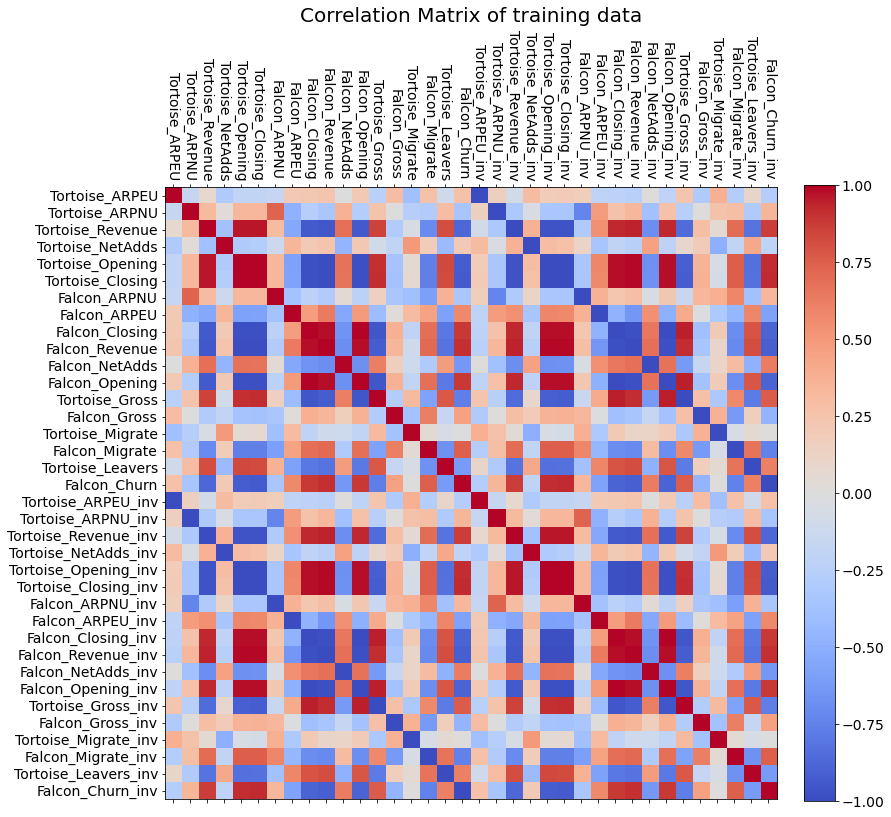

In [20]:
f = plt.figure(figsize=(12, 12))
plt.matshow(train_corr, fignum=f.number, cmap='coolwarm')
plt.xticks(range(len(data_var)), data_var, fontsize=14, rotation=270)
plt.yticks(range(len(data_var)), data_var, fontsize=14)
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix of training data', fontsize=20, y=1.26)
plt.show()

In [21]:
def data_reshape(df):
    # reshape df to get features
    df = df.set_index('Timestamp').stack().reset_index()
    df.columns = ['Timestamp','Variable','Z_score']
    df = df.sort_values(['Variable','Timestamp']).reset_index(drop=True)
    df['target'] = df['Z_score'].values
    
    # add month_id as the month feature
    month_unq = np.unique(df['Timestamp'])
    month_dict = dict(zip(month_unq, np.arange(len(month_unq))))
    print ("month_dict:", len(month_dict), month_dict)
    df['month_id'] = df['Timestamp'].apply(lambda x:month_dict[x])
    return df

In [22]:
train_df = data_reshape(train_df)
train_df

month_dict: 42 {'2016-04-01': 0, '2016-05-01': 1, '2016-06-01': 2, '2016-07-01': 3, '2016-08-01': 4, '2016-09-01': 5, '2016-10-01': 6, '2016-11-01': 7, '2016-12-01': 8, '2017-01-01': 9, '2017-02-01': 10, '2017-03-01': 11, '2017-04-01': 12, '2017-05-01': 13, '2017-06-01': 14, '2017-07-01': 15, '2017-08-01': 16, '2017-09-01': 17, '2017-10-01': 18, '2017-11-01': 19, '2017-12-01': 20, '2018-01-01': 21, '2018-02-01': 22, '2018-03-01': 23, '2018-04-01': 24, '2018-05-01': 25, '2018-06-01': 26, '2018-07-01': 27, '2018-08-01': 28, '2018-09-01': 29, '2018-10-01': 30, '2018-11-01': 31, '2018-12-01': 32, '2019-01-01': 33, '2019-02-01': 34, '2019-03-01': 35, '2019-04-01': 36, '2019-05-01': 37, '2019-06-01': 38, '2019-07-01': 39, '2019-08-01': 40, '2019-09-01': 41}


,Timestamp,Variable,Z_score,target,month_id
0,2016-04-01,Falcon_ARPEU,-0.726293,-0.726293,0
1,2016-05-01,Falcon_ARPEU,0.090185,0.090185,1
2,2016-06-01,Falcon_ARPEU,-0.337763,-0.337763,2
3,2016-07-01,Falcon_ARPEU,-0.555518,-0.555518,3
4,2016-08-01,Falcon_ARPEU,-0.586447,-0.586447,4
...,...,...,...,...,...
1507,2019-05-01,Tortoise_Revenue_inv,0.857420,0.857420,37
1508,2019-06-01,Tortoise_Revenue_inv,0.905089,0.905089,38
1509,2019-07-01,Tortoise_Revenue_inv,0.957934,0.957934,39
1510,2019-08-01,Tortoise_Revenue_inv,1.110593,1.110593,40


In [23]:
test_df = data_reshape(test_df)
train_month_id_max = np.max(train_df['month_id'])
print(f"train_month_id_max = {train_month_id_max}")
test_df['month_id'] += train_month_id_max + 1
test_df

month_dict: 6 {'2019-10-01': 0, '2019-11-01': 1, '2019-12-01': 2, '2020-01-01': 3, '2020-02-01': 4, '2020-03-01': 5}
train_month_id_max = 41


,Timestamp,Variable,Z_score,target,month_id
0,2019-10-01,Falcon_ARPEU,0.009180,0.009180,42
1,2019-11-01,Falcon_ARPEU,0.033835,0.033835,43
2,2019-12-01,Falcon_ARPEU,-0.228040,-0.228040,44
3,2020-01-01,Falcon_ARPEU,-0.519837,-0.519837,45
4,2020-02-01,Falcon_ARPEU,-1.403620,-1.403620,46
5,2020-03-01,Falcon_ARPEU,-1.883290,-1.883290,47
6,2019-10-01,Falcon_ARPNU,-1.651663,-1.651663,42
7,2019-11-01,Falcon_ARPNU,-1.442524,-1.442524,43
8,2019-12-01,Falcon_ARPNU,-1.754209,-1.754209,44
9,2020-01-01,Falcon_ARPNU,-1.345226,-1.345226,45


In [24]:
# add initialized features for training data
def init_features(df, df_corr):
    # add features of year, month, month_id, Quarter, month_in_Quarter
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['year'] = df['Timestamp'].dt.year
    df['month'] = df['Timestamp'].dt.month
    df['YYYYMM'] = df['year'] * 100 + df['month']
    Quarter_dict = {4:1, 5:1, 6:1, 7:2, 8:2, 9:2, 10:3, 11:3, 12:3, 1:4, 2:4, 3:4}
    Quarter_month_dict = {4:1, 5:2, 6:3, 7:1, 8:2, 9:3, 10:1, 11:2, 12:3, 1:1, 2:2, 3:3}
    df['Quarter'] = df['month'].apply(lambda x: Quarter_dict[x])
    df['month_in_Quarter'] = df['month'].apply(lambda x: Quarter_month_dict[x])
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.strftime("%Y-%m-%d"))
    
    # add variable correlations to each variable (only in training train)
    df_corr = df_corr.reset_index()
    df_corr.rename(columns={'index':'Variable'}, inplace=True)
    df = df.merge(df_corr, how="left", left_index=True, on=['Variable'])
    df = df.reset_index(drop=True)
    return df

In [25]:
train_df = init_features(train_df, train_corr)
train_df

,Timestamp,Variable,Z_score,target,month_id,year,month,YYYYMM,Quarter,month_in_Quarter,...,Falcon_Closing_inv,Falcon_Revenue_inv,Falcon_NetAdds_inv,Falcon_Opening_inv,Tortoise_Gross_inv,Falcon_Gross_inv,Tortoise_Migrate_inv,Falcon_Migrate_inv,Tortoise_Leavers_inv,Falcon_Churn_inv
0,2016-04-01,Falcon_ARPEU,-0.726293,-0.726293,0,2016,4,201604,1,1,...,-0.474898,-0.640559,0.539388,-0.486135,0.399336,-0.022073,-0.312150,-0.449331,0.583138,-0.574534
1,2016-05-01,Falcon_ARPEU,0.090185,0.090185,1,2016,5,201605,1,2,...,-0.474898,-0.640559,0.539388,-0.486135,0.399336,-0.022073,-0.312150,-0.449331,0.583138,-0.574534
2,2016-06-01,Falcon_ARPEU,-0.337763,-0.337763,2,2016,6,201606,1,3,...,-0.474898,-0.640559,0.539388,-0.486135,0.399336,-0.022073,-0.312150,-0.449331,0.583138,-0.574534
3,2016-07-01,Falcon_ARPEU,-0.555518,-0.555518,3,2016,7,201607,2,1,...,-0.474898,-0.640559,0.539388,-0.486135,0.399336,-0.022073,-0.312150,-0.449331,0.583138,-0.574534
4,2016-08-01,Falcon_ARPEU,-0.586447,-0.586447,4,2016,8,201608,2,2,...,-0.474898,-0.640559,0.539388,-0.486135,0.399336,-0.022073,-0.312150,-0.449331,0.583138,-0.574534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,2019-05-01,Tortoise_Revenue_inv,0.857420,0.857420,37,2019,5,201905,1,2,...,-0.933882,-0.938865,0.684303,-0.937141,0.855182,-0.282169,-0.052846,-0.699238,0.816682,-0.867200
1508,2019-06-01,Tortoise_Revenue_inv,0.905089,0.905089,38,2019,6,201906,1,3,...,-0.933882,-0.938865,0.684303,-0.937141,0.855182,-0.282169,-0.052846,-0.699238,0.816682,-0.867200
1509,2019-07-01,Tortoise_Revenue_inv,0.957934,0.957934,39,2019,7,201907,2,1,...,-0.933882,-0.938865,0.684303,-0.937141,0.855182,-0.282169,-0.052846,-0.699238,0.816682,-0.867200
1510,2019-08-01,Tortoise_Revenue_inv,1.110593,1.110593,40,2019,8,201908,2,2,...,-0.933882,-0.938865,0.684303,-0.937141,0.855182,-0.282169,-0.052846,-0.699238,0.816682,-0.867200


In [26]:
max_previous_months = 18  # from current month (0) to previous n months
min_recent_months = 0 
max_recent_months = 17
print(f"max_previous_months = {max_previous_months}")
print(f"min_recent_months = {min_recent_months}")
print(f"max_recent_months = {max_recent_months}")

def get_features(df, month_id, forecasting_months, drop_null_targets, verbose=True):
    month_df = df.loc[df['month_id']==month_id].copy()    
    month_df['month_id_features'] = month_id  # to save the month_id of features coming from
    if verbose == True:
        print(f"month_id={month_id}, initial month_df:{month_df.shape}, forecasting_months={forecasting_months}")
    
    # Get historical variables
    keys = ['Variable','month_id']
    feat = 'Z_score'
    target_df = month_df[keys].copy()  # save forecasting targets
    for i in range(1, forecasting_months + 1):  # merge next 1,2,3,... months
        target_df['month_id'] = month_id + i # modify month_id
        merge_df = target_df[keys].merge(df[keys+[feat]], how="left", left_index=True, on=keys)
        target_df[f"{feat}_n{i}"] = merge_df[feat].values 
    target_df['month_id'] = month_id # restore month_id
    
    prev_feat = []
    prev_log = []
    for i in range(max_previous_months):  # current month: _p0
        month_df['month_id'] = month_id - i # modify month_id
        # merge next 1,2,3,4,5,6 months here!
        merge_df = month_df[keys].merge(df[keys+[feat]], how="left", left_index=True, on=keys)
        month_df[f"{feat}_p{i}"] = merge_df[feat].values 
        prev_feat.append(f"{feat}_p{i}")
        month_df[f"{feat}_mean{i}"] = month_df[prev_feat].mean(axis=1)            
        month_df[f"{feat}_std{i}"] = month_df[prev_feat].std(axis=1).fillna(1) 
        month_df.loc[month_df[f"{feat}_std{i}"]==0, f"{feat}_std{i}"] = 1  # avoid dividing 0
        month_df[f"{feat}_min{i}"] = month_df[prev_feat].min(axis=1) 
        month_df[f"{feat}_max{i}"] = month_df[prev_feat].max(axis=1) 
        month_df[f"{feat}_ptp{i}"] = month_df[f"{feat}_max{i}"] - month_df[f"{feat}_min{i}"] 
            
    if verbose == True:
        print ("month_id=%d, historical features=%s, max_previous_months=%d, month_df.shape=%s"%(month_id,
                                            feat, max_previous_months, month_df.shape))
    month_df['month_id'] = month_id # restore month_id
        
    # rescale features and targets based on recent_mean
    prev_scale = [c+'S' for c in month_df.columns if ('Z_score_p' in c) and ('_ptp' not in c)]
    prev_score = [c for c in month_df.columns if ('Z_score_p' in c) and ('_ptp' not in c)]
    prev_norm = [c+'N' for c in month_df.columns if ('Z_score_p' in c) and ('_ptp' not in c)]    
    month_new = []
    #print(f"#prev_log={len(prev_log)}, {prev_log}")
    for i in range(min_recent_months, max_recent_months+1):  # based on recent i months
        # keep recent i months and calculate the mean
        month_df_i = month_df.copy()
        month_df_i['recent_group'] = i
        month_df_i[prev_score[i:]] = np.nan  # keep recent months only
        month_df_i['recent_mean'] = month_df_i[f"Z_score_mean{i}"] 
        month_df_i['recent_std'] = month_df_i[f"Z_score_std{i}"] 
        month_df_i['recent_min'] = month_df_i[f"Z_score_min{i}"]
        month_df_i['recent_max'] = month_df_i[f"Z_score_max{i}"]
        month_df_i['recent_ptp'] = month_df_i[f"Z_score_ptp{i}"]
        
        # rescale features and targets            
        for j in range(len(prev_score)):
            c = prev_score[j]
            if j >= i:  # keep recent months only
                month_df_i[c+'S'] = np.nan
                month_df_i[c+'N'] = np.nan 
            else:
                month_df_i[c+'S'] = month_df_i[c] / month_df_i['recent_std']
                month_df_i[c] -= month_df_i['recent_mean']
                month_df_i[c+'N'] = month_df_i[c] / month_df_i['recent_std']            
        # month_df_i['Z_score'] -= month_df_i['recent_mean']
            
        if i == 0 and verbose == True:
            print ("month_id=%d, i=%d: add recent(group,mean,std), prev_scale, and prev_norm: %s\n"%(
                month_id, i, month_df_i.shape))
    
        # Combine historical features from different target variables
        merge_cols = ['month_id','recent_mean','recent_std','recent_min','recent_max','recent_ptp']
        merge_cols += prev_scale + prev_score + prev_norm
        # print(f"#merge_cols = {len(merge_cols)}, {merge_cols}")
        for j in range(len(data_var)):               
            var_df = month_df_i.loc[month_df_i['Variable']==data_var[j], merge_cols]            
            month_df_i = month_df_i.merge(var_df, how="left", left_index=True, on='month_id',
                                  suffixes=('','_'+data_var[j]))
            month_df_i = month_df_i.reset_index(drop=True)
                
            if i == 0 and verbose == True:
                print ("month_id=%d, j=%d, var_df:%s, month_df_i:%s, merge %s"%(month_id, j,
                            var_df.shape, month_df_i.shape, data_var[j]))
                
        # merge next 1,2,3,... months
        month_df_i['forecast_n'] = np.nan  # forecasting month indicator
        for j in range(1, forecasting_months + 1): 
            month_df_j = month_df_i.copy()  # use same features of month_df_i, but different targets
            month_df_j['forecast_n'] = j  # forecasting month indicator
            feat_j = f"{feat}_n{j}"  # forecasting targets
            merge_df = month_df_j[keys].merge(target_df[keys+[feat_j]], how="left", left_index=True, on=keys)
            month_df_j['Z_score'] = merge_df[feat_j].values
            month_df_j['Z_score'] -= month_df_j['recent_mean']
            month_df_j['month_id'] += j # update month_id for forecasting (original month_id: month_id_features)
            if drop_null_targets:
                month_df_j = month_df_j.loc[pd.notnull(month_df_j['Z_score'])]
            month_new.append(month_df_j)
            
        if verbose == True:
            print ("month_id=%d, rescale i=%d: forecasting_months=%d, #month_new=%d, #data_var=%d, #samples=%d"%(
                    month_id, i, forecasting_months, len(month_new), len(data_var), 
                    len(month_new) * month_df_i.shape[0]))        
        
    month_new = pd.concat(month_new, ignore_index=True)
    if verbose == True:
        print("recent_group:", Counter(month_new['recent_group']))
        print("")
    print ("get_features: month_id = %d, month_new.shape = %s"%(month_id, month_new.shape))
        
    return month_new

max_previous_months = 18
min_recent_months = 0
max_recent_months = 17


In [27]:
# generate training features
def get_train_features(train_df, forecasting_months):
    drop_null_targets = True
    print(f"generate training features: drop_null_targets = {drop_null_targets}")
    train_features = []
    train_month_id_start = 0
    for month_id in range(train_month_id_start, train_month_id_max):  
        verbose = True if month_id==train_month_id_start else False
        month_df = get_features(train_df, month_id, forecasting_months, drop_null_targets, verbose)
        train_features.append(month_df)
    train_features = pd.concat(train_features).sort_values(['Variable','month_id']).reset_index(drop=True)
    return train_features

In [28]:
train_features = get_train_features(train_df, forecasting_months)
train_features  # 276,048 rows × 2,322 columns

generate training features: drop_null_targets = True
month_id=0, initial month_df:(36, 47), forecasting_months=12
month_id=0, historical features=Z_score, max_previous_months=18, month_df.shape=(36, 155)
month_id=0, i=0: add recent(group,mean,std), prev_scale, and prev_norm: (36, 197)

month_id=0, j=0, var_df:(1, 60), month_df_i:(36, 256), merge Tortoise_ARPEU
month_id=0, j=1, var_df:(1, 60), month_df_i:(36, 315), merge Tortoise_ARPNU
month_id=0, j=2, var_df:(1, 60), month_df_i:(36, 374), merge Tortoise_Revenue
month_id=0, j=3, var_df:(1, 60), month_df_i:(36, 433), merge Tortoise_NetAdds
month_id=0, j=4, var_df:(1, 60), month_df_i:(36, 492), merge Tortoise_Opening
month_id=0, j=5, var_df:(1, 60), month_df_i:(36, 551), merge Tortoise_Closing
month_id=0, j=6, var_df:(1, 60), month_df_i:(36, 610), merge Falcon_ARPNU
month_id=0, j=7, var_df:(1, 60), month_df_i:(36, 669), merge Falcon_ARPEU
month_id=0, j=8, var_df:(1, 60), month_df_i:(36, 728), merge Falcon_Closing
month_id=0, j=9, var_df:(

,Timestamp,Variable,Z_score,target,month_id,year,month,YYYYMM,Quarter,month_in_Quarter,...,Z_score_p9N_Falcon_Churn_inv,Z_score_p10N_Falcon_Churn_inv,Z_score_p11N_Falcon_Churn_inv,Z_score_p12N_Falcon_Churn_inv,Z_score_p13N_Falcon_Churn_inv,Z_score_p14N_Falcon_Churn_inv,Z_score_p15N_Falcon_Churn_inv,Z_score_p16N_Falcon_Churn_inv,Z_score_p17N_Falcon_Churn_inv,forecast_n
0,2016-04-01,Falcon_ARPEU,0.816478,-0.726293,1,2016,4,201604,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2016-04-01,Falcon_ARPEU,0.816478,-0.726293,1,2016,4,201604,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2016-04-01,Falcon_ARPEU,0.816478,-0.726293,1,2016,4,201604,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2016-04-01,Falcon_ARPEU,0.816478,-0.726293,1,2016,4,201604,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2016-04-01,Falcon_ARPEU,0.816478,-0.726293,1,2016,4,201604,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276043,2019-08-01,Tortoise_Revenue_inv,0.512532,1.110593,41,2019,8,201908,2,2,...,0.064576,0.081571,0.120950,0.908530,NaN,NaN,NaN,NaN,NaN,1
276044,2019-08-01,Tortoise_Revenue_inv,0.525004,1.110593,41,2019,8,201908,2,2,...,-0.069291,-0.053957,-0.018426,0.692185,1.449547,NaN,NaN,NaN,NaN,1
276045,2019-08-01,Tortoise_Revenue_inv,0.566296,1.110593,41,2019,8,201908,2,2,...,-0.136726,-0.121446,-0.086042,0.622043,1.376712,1.711747,NaN,NaN,NaN,1
276046,2019-08-01,Tortoise_Revenue_inv,0.592495,1.110593,41,2019,8,201908,2,2,...,-0.207551,-0.192499,-0.157623,0.539900,1.283313,1.613352,0.927209,NaN,NaN,1


# Model and validate

- The LightGBM model will be used for training and validation

### Evaluation metrics
- MAPE

In [29]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
def lgb_mape(preds, train_data):
    # self-defined eval metric
    # f(preds: array, train_data: Dataset) -> name: string, value: array, is_higher_better: bool
    labels = train_data.get_label()
    score = np.mean(np.abs((labels - preds) / labels)) * 100
    return 'lgb_mape', score, False  

In [31]:
not_features = ['Timestamp', 'Variable', 'Z_score', 'target','month_id_features']
features = [c for c in train_features.columns if c not in not_features]
print(f"not_features = {not_features}\n")
print(f"#features = {len(features)}, {features}, {len(features)}")

not_features = ['Timestamp', 'Variable', 'Z_score', 'target', 'month_id_features']

#features = 2317, ['month_id', 'year', 'month', 'YYYYMM', 'Quarter', 'month_in_Quarter', 'Tortoise_ARPEU', 'Tortoise_ARPNU', 'Tortoise_Revenue', 'Tortoise_NetAdds', 'Tortoise_Opening', 'Tortoise_Closing', 'Falcon_ARPNU', 'Falcon_ARPEU', 'Falcon_Closing', 'Falcon_Revenue', 'Falcon_NetAdds', 'Falcon_Opening', 'Tortoise_Gross', 'Falcon_Gross', 'Tortoise_Migrate', 'Falcon_Migrate', 'Tortoise_Leavers', 'Falcon_Churn', 'Tortoise_ARPEU_inv', 'Tortoise_ARPNU_inv', 'Tortoise_Revenue_inv', 'Tortoise_NetAdds_inv', 'Tortoise_Opening_inv', 'Tortoise_Closing_inv', 'Falcon_ARPNU_inv', 'Falcon_ARPEU_inv', 'Falcon_Closing_inv', 'Falcon_Revenue_inv', 'Falcon_NetAdds_inv', 'Falcon_Opening_inv', 'Tortoise_Gross_inv', 'Falcon_Gross_inv', 'Tortoise_Migrate_inv', 'Falcon_Migrate_inv', 'Tortoise_Leavers_inv', 'Falcon_Churn_inv', 'Z_score_p0', 'Z_score_mean0', 'Z_score_std0', 'Z_score_min0', 'Z_score_max0', 'Z_score_ptp0', 'Z_s

In [32]:
LGB_param_init = {'objective':'regression_l2', #'huber', #'regression_l2', 'regression_l1', 'mape'               
                'num_leaves': 4, #2>4>8>16
                'min_data_in_leaf': 20, #Good: 10, 20, 30, 50
                'lambda_l1': 0.01, #0.1>0.01>1
                'max_depth': -1, # -1>8
                'max_bin': 128, #128>64>256
                'learning_rate': 0.03, #0.03 is the best
                'boosting': 'gbdt',
                'feature_fraction': 0.7, #0.7>0.8, 
                'bagging_freq': 0,  # 0 or 1
                'bagging_fraction': 0.9,
                'bagging_seed': 42,
                'metric': 'rmse', #'lgb_mape', #'mape', #'rmse',
                'verbosity': -1,
                'thread': 4}
print ("LightGBM param_init:")
LGB_param_init

LightGBM param_init:


{'objective': 'regression_l2',
 'num_leaves': 4,
 'min_data_in_leaf': 20,
 'lambda_l1': 0.01,
 'max_depth': -1,
 'max_bin': 128,
 'learning_rate': 0.03,
 'boosting': 'gbdt',
 'feature_fraction': 0.7,
 'bagging_freq': 0,
 'bagging_fraction': 0.9,
 'bagging_seed': 42,
 'metric': 'rmse',
 'verbosity': -1,
 'thread': 4}

In [33]:
XGB_param_init = {'objective': 'reg:squarederror',  # 'reg:squarederror, squaredlogerror, linear'
                  'tree_method': 'hist',
                  'min_child_weight': 1,  # 1=5
                  'eta': 0.01,  # 0.02>0.01?,
                  'max_bin': 256,
                  'gamma': 1,  # 0=1, 5
                  "booster": "gbtree",
                  "colsample_bytree": 0.8,  # 0.8, #0.8>0.85>0.9>0.7,
                  "subsample": 0.8,  # 0.8=0.9
                  "eval_metric": 'rmse',
                  "lambda": 0.01,
                  "nthread": 4,
                  "seed": 2020}
print ("XGB_param_init:")
XGB_param_init

XGB_param_init:


{'objective': 'reg:squarederror',
 'tree_method': 'hist',
 'min_child_weight': 1,
 'eta': 0.01,
 'max_bin': 256,
 'gamma': 1,
 'booster': 'gbtree',
 'colsample_bytree': 0.8,
 'subsample': 0.8,
 'eval_metric': 'rmse',
 'lambda': 0.01,
 'nthread': 4,
 'seed': 2020}

In [34]:
# Optimize gradient-based hyperparameters by the experimental analysis of trial and error learning
LGB_num_leaves = [8, 32, 32, 8]
LGB_max_depth = [6, 5, 6, 5]
LGB_learning_rate = [0.002, 0.02, 0.02, 0.02]
LGB_bagging_freq = [1, 0, 1, 0]
LGB_feature_fraction = [0.8, 0.8, 0.8, 0.8]
LGB_min_data_in_leaf = [20, 20, 20, 20]
LGB_max_bin = [32, 32, 32, 16]
LGB_lambda_l1 = [0.5, 0.01, 0.01, 0.01]
LGB_boost_from_average = [False, True, True, True]
LGB_recent_group = [[0,1], [0,5], [0,7], [0,2]]
LGB_month_id_period = [[0,-1], [0,-1], [12,-1], [0,-1]]
LGB_num_rounds = [22, 267, 266, 18]
print(f"#LGB_num_leaves = {len(LGB_num_leaves)}, {LGB_num_leaves}")
print(f"#LGB_max_depth = {len(LGB_max_depth)}, {LGB_max_depth}")
print(f"#LGB_learning_rate = {len(LGB_learning_rate)}, {LGB_learning_rate}")
print(f"#LGB_bagging_freq = {len(LGB_bagging_freq)}, {LGB_bagging_freq}")
print(f"#LGB_feature_fraction = {len(LGB_feature_fraction)}, {LGB_feature_fraction}")
print(f"#LGB_min_data_in_leaf = {len(LGB_min_data_in_leaf)}, {LGB_min_data_in_leaf}")
print(f"#LGB_max_bin = {len(LGB_max_bin)}, {LGB_max_bin}")
print(f"#LGB_lambda_l1 = {len(LGB_lambda_l1)}, {LGB_lambda_l1}")
print(f"#LGB_recent_group = {len(LGB_recent_group)}, {LGB_recent_group}")
print(f"#LGB_month_id_period = {len(LGB_month_id_period)}, {LGB_month_id_period}")
print(f"#LGB_num_rounds = {len(LGB_num_rounds)}, {LGB_num_rounds}")

#LGB_num_leaves = 4, [8, 32, 32, 8]
#LGB_max_depth = 4, [6, 5, 6, 5]
#LGB_learning_rate = 4, [0.002, 0.02, 0.02, 0.02]
#LGB_bagging_freq = 4, [1, 0, 1, 0]
#LGB_feature_fraction = 4, [0.8, 0.8, 0.8, 0.8]
#LGB_min_data_in_leaf = 4, [20, 20, 20, 20]
#LGB_max_bin = 4, [32, 32, 32, 16]
#LGB_lambda_l1 = 4, [0.5, 0.01, 0.01, 0.01]
#LGB_recent_group = 4, [[0, 1], [0, 5], [0, 7], [0, 2]]
#LGB_month_id_period = 4, [[0, -1], [0, -1], [12, -1], [0, -1]]
#LGB_num_rounds = 4, [22, 267, 266, 18]


In [35]:
# Optimize gradient-based hyperparameters by the experimental analysis of trial and error learning
XGB_max_depth = [8]
XGB_eta = [0.02]
XGB_subsample = [0.9]
XGB_colsample_bytree = [0.85]
XGB_max_bin = [64]
XGB_lambda = [0.5]
XGB_recent_group = [[0,17]]
XGB_month_id_period = [[-12,-1]]
XGB_num_rounds = [253]
print(f"#XGB_max_depth = {len(XGB_max_depth)}, {XGB_max_depth}")
print(f"#XGB_eta = {len(XGB_eta)}, {XGB_eta}")
print(f"#XGB_subsample = {len(XGB_subsample)}, {XGB_subsample}")
print(f"#XGB_colsample_bytree = {len(XGB_colsample_bytree)}, {XGB_colsample_bytree}")
print(f"#XGB_max_bin = {len(XGB_max_bin)}, {XGB_max_bin}")
print(f"#XGB_lambda = {len(XGB_lambda)}, {XGB_lambda}")
print(f"#XGB_recent_group = {len(XGB_recent_group)}, {XGB_recent_group}")
print(f"#XGB_month_id_period = {len(XGB_month_id_period)}, {XGB_month_id_period}")
print(f"#XGB_num_rounds = {len(XGB_num_rounds)}, {XGB_num_rounds}")

#XGB_max_depth = 1, [8]
#XGB_eta = 1, [0.02]
#XGB_subsample = 1, [0.9]
#XGB_colsample_bytree = 1, [0.85]
#XGB_max_bin = 1, [64]
#XGB_lambda = 1, [0.5]
#XGB_recent_group = 1, [[0, 17]]
#XGB_month_id_period = 1, [[-12, -1]]
#XGB_num_rounds = 1, [253]


In [36]:
def LGB_training(iteration, var_id):   
    var = challenge_targets[var_id]
    param = LGB_param_init.copy()
    param['num_leaves'] = LGB_num_leaves[var_id]
    param['max_depth'] = LGB_max_depth[var_id]
    param['learning_rate'] = LGB_learning_rate[var_id]
    param['bagging_freq'] = LGB_bagging_freq[var_id]
    param['feature_fraction'] = LGB_feature_fraction[var_id]
    param['min_data_in_leaf'] = LGB_min_data_in_leaf[var_id]
    param['max_bin'] = LGB_max_bin[var_id]
    param['lambda_l1'] = LGB_lambda_l1[var_id]
    param['boost_from_average'] = LGB_boost_from_average[var_id]
    group_min, group_max = LGB_recent_group[var_id][0], LGB_recent_group[var_id][1]
    month_start, month_end = LGB_month_id_period[var_id][0], LGB_month_id_period[var_id][1]
    num_round = LGB_num_rounds[var_id]
    if month_start < 0:
        month_start += train_month_id_max
    if month_end < -1:
        month_end += train_month_id_max
    print(f"iteration={iteration}, var_id={var_id}, LightGBM parameter: {param}")
    print(f"iteration={iteration}, var_id={var_id}, target = {var}, group_min = {group_min}, group_max = {group_max}, month_id_period: "
          f"{month_start, month_end}")
    
    if var_id in [0, 1, 2, 3]:
        weight = (train_features[var]+1)/2        
    else:
        weight = np.ones(len(train_features)) 
    
    trn_group_idx = (train_features['recent_group']>=group_min) & (train_features['recent_group']<=group_max)
   
    drop_features = []
    if var_id in [0, 2]:
        drop_features += ['month_id','year','month','YYYYMM','Quarter','month_in_Quarter']
    features1 = [c for c in features if c not in drop_features]
    
    trn_idx = trn_group_idx & ((train_features['month_id_features'] >= month_start) | 
                               (train_features['month_id'] >= month_start))
    if month_end > -1:
        trn_idx = trn_idx & ((train_features['month_id_features'] <= month_end) | 
                             (train_features['month_id'] <= month_end))
    # if var_id in [0]:
    #     trn_idx = trn_idx & (weight > 0.5)
    print(f"iteration={iteration}, var_id={var_id}, sample weight = {np.percentile(weight[trn_idx], [0,25,50,75,100])}")
        
    trn_train, trn_target = train_features.loc[trn_idx, features1], train_features.loc[trn_idx, 'Z_score']
    trn_data = lgb.Dataset(trn_train, label=trn_target, weight=weight[trn_idx])
    print(f"iteration={iteration}, var_id={var_id}, trn_train.shape={trn_train.shape}, num_round={num_round}")
    
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data], verbose_eval=10)  #, feval=lgb_mape)
    model_file = f"{var}_LGB.model"
    clf.save_model(model_file)
    print (f"iteration={iteration}, var_id={var_id}, save model to {model_file}\n")

    if iteration == 0:
        #--------- get feature importance ---------   
        imp_df = pd.DataFrame({'feature':features1, 'imp':clf.feature_importance()})
        imp_df = imp_df.sort_values("imp").reset_index(drop=True)
        print (imp_df)
        imp_file = f"{var}_importance_LGB.csv"
        imp_df.to_csv(imp_file, index=False)
        print (f"iteration={iteration}, var_id={var_id}, Wrote {imp_file}")
        
    print ("-"*100)
    print ("")

In [37]:
def XGB_training(iteration, var_id):   
    var = challenge_targets[var_id]
    param = XGB_param_init.copy()
    param['max_depth'] = XGB_max_depth[var_id]
    param['eta'] = XGB_eta[var_id]
    param['subsample'] = XGB_subsample[var_id]
    param['colsample_bytree'] = XGB_colsample_bytree[var_id]
    param['max_bin'] = XGB_max_bin[var_id]
    param['lambda'] = XGB_lambda[var_id]
    group_min, group_max = XGB_recent_group[var_id][0], XGB_recent_group[var_id][1]
    month_start, month_end = XGB_month_id_period[var_id][0], XGB_month_id_period[var_id][1]
    num_round = XGB_num_rounds[var_id]
    if month_start < 0:
        month_start += train_month_id_max
    if month_end < -1:
        month_end += train_month_id_max
    print(f"iteration={iteration}, var_id={var_id}, XGBoost parameter: {param}")
    print(f"iteration={iteration}, var_id={var_id}, target = {var}, group_min = {group_min}, group_max = {group_max}, month_id_period: "
          f"{month_start, month_end}")
    
    if var_id in [0, 1, 2, 3]:
        weight = (train_features[var]+1)/2        
    else:
        weight = np.ones(len(train_features)) 
    
    trn_group_idx = (train_features['recent_group']>=group_min) & (train_features['recent_group']<=group_max)
    
    drop_features = []
    if var_id in [0, 2]:
        drop_features += ['month_id','year','month','YYYYMM','Quarter','month_in_Quarter']
    features1 = [c for c in features if c not in drop_features]
    
    trn_idx = trn_group_idx & ((train_features['month_id_features'] >= month_start) | 
                               (train_features['month_id'] >= month_start))
    if month_end > -1:
        trn_idx = trn_idx & ((train_features['month_id_features'] <= month_end) | 
                             (train_features['month_id'] <= month_end))
    print(f"iteration={iteration}, var_id={var_id}, sample weight = {np.percentile(weight[trn_idx], [0,25,50,75,100])}")
        
    trn_train, trn_target = train_features.loc[trn_idx, features1], train_features.loc[trn_idx, 'Z_score']
    print(f"iteration={iteration}, var_id={var_id}, trn_train.shape={trn_train.shape}, num_round={num_round}")
    trn_data = xgb.DMatrix(trn_train, trn_target, weight=weight[trn_idx])
    clf = xgb.train(param, trn_data, num_round, [(trn_data, 'train')], verbose_eval=10,
                    early_stopping_rounds=50)  # feval
    
    model_file = f"{var}_XGB.model"
    clf.save_model(model_file)
    print (f"iteration={iteration}, var_id={var_id}, save model to {model_file}\n")
    
    if iteration == 0:
        #--------- get feature importance ---------   
        imp_df = pd.DataFrame(clf.get_score(importance_type='gain').items(), columns=['feature', 'imp'])
        imp_df = imp_df.sort_values("imp").reset_index(drop=True)
        print (imp_df)
        imp_file = f"{var}_importance_XGB.csv"
        imp_df.to_csv(imp_file, index=False)
        print ("Wrote %s\n"%(imp_file))
    print ("-"*100)
    print ("")

In [38]:
iteration = 0
for var_id in range(len(challenge_targets)):
    LGB_training(iteration, var_id) 
    if var_id == 0:
        XGB_training(iteration, var_id)

iteration=0, var_id=0, LightGBM parameter: {'objective': 'regression_l2', 'num_leaves': 8, 'min_data_in_leaf': 20, 'lambda_l1': 0.5, 'max_depth': 6, 'max_bin': 32, 'learning_rate': 0.002, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'bagging_freq': 1, 'bagging_fraction': 0.9, 'bagging_seed': 42, 'metric': 'rmse', 'verbosity': -1, 'thread': 4, 'boost_from_average': False}
iteration=0, var_id=0, target = Falcon_ARPNU, group_min = 0, group_max = 1, month_id_period: (0, -1)
iteration=0, var_id=0, sample weight = [0.         0.33558751 0.5        0.66441249 1.        ]
iteration=0, var_id=0, trn_train.shape=(30672, 2311), num_round=22
[10]	training's rmse: 0.942901
[20]	training's rmse: 0.935888
iteration=0, var_id=0, save model to Falcon_ARPNU_LGB.model

                                feature  imp
0                        Tortoise_ARPEU    0
1     Z_score_p11N_Tortoise_Opening_inv    0
2     Z_score_p12N_Tortoise_Opening_inv    0
3     Z_score_p13N_Tortoise_Opening_inv    0
4     Z_score_

iteration=0, var_id=3, trn_train.shape=(46008, 2317), num_round=18
[10]	training's rmse: 0.858952
iteration=0, var_id=3, save model to Falcon_Migrate_LGB.model

                                feature  imp
0                              month_id    0
1      Z_score_p9N_Tortoise_Opening_inv    0
2     Z_score_p10N_Tortoise_Opening_inv    0
3     Z_score_p11N_Tortoise_Opening_inv    0
4     Z_score_p12N_Tortoise_Opening_inv    0
...                                 ...  ...
2312                 Falcon_Migrate_inv    8
2313                     Z_score_mean17    8
2314                       Z_score_max8   15
2315                         forecast_n   27
2316                        recent_mean   28

[2317 rows x 2 columns]
iteration=0, var_id=3, Wrote Falcon_Migrate_importance_LGB.csv
----------------------------------------------------------------------------------------------------



In [39]:
# generate test features
def get_test_features(train_df, forecasting_months, test_df):
    drop_null_targets = False
    print(f"generate test_features: drop_null_targets = {drop_null_targets}")
    periods = train_month_id_max + forecasting_months + 1
    month_id_to_date = pd.date_range(start=start_date_train, periods=periods, freq='MS').astype(str).tolist()
    month_id_dict = dict(zip(np.arange(len(month_id_to_date)), month_id_to_date))
    # test_features = get_features(train_df, train_month_id_max, forecasting_months, drop_null_targets)    
    test_features = []
    test_month_id_start = train_month_id_max # train_month_id_max - 11
    for month_id in range(test_month_id_start, train_month_id_max + 1):  
        verbose = True if month_id==test_month_id_start else False
        month_df = get_features(train_df, month_id, forecasting_months, drop_null_targets, verbose)
        test_features.append(month_df)
    test_features = pd.concat(test_features).sort_values(['Variable','month_id']).reset_index(drop=True)
    test_features = test_features.loc[test_features['Variable'].isin(challenge_targets)].reset_index(drop=True)
    test_features = test_features.loc[test_features['month_id'] > train_month_id_max].reset_index(drop=True)
    keys = ['Variable','month_id']
    # merge targets of test_df for checking RMSE and MAPE score only!
    merge_df = test_features[keys].merge(test_df[keys+['target']], how="left", left_index=True, on=keys)
    test_features['Timestamp'] = test_features['month_id'].apply(lambda x: month_id_dict[x])
    test_features['target'] = merge_df['target'].values
    test_features['Z_score'] = test_features['target'] - test_features['recent_mean'] 
    
    var_size = len(challenge_targets)
    group_size = max_recent_months - min_recent_months + 1
    sample_size = var_size * group_size * forecasting_months
    print(f"test_features: #not_null(Z_score) = {np.sum(pd.notnull(test_features['Z_score']))}\n")
    print(f"{var_size} challenge_targets * {group_size} recent_group * {forecasting_months} forecasting_months = "
          f"{sample_size} samples of test features")
    return test_features

In [40]:
test_features = get_test_features(train_df, forecasting_months, test_df)
test_features  # 864 rows × 2,322 columns

generate test_features: drop_null_targets = False
month_id=41, initial month_df:(36, 47), forecasting_months=12
month_id=41, historical features=Z_score, max_previous_months=18, month_df.shape=(36, 155)
month_id=41, i=0: add recent(group,mean,std), prev_scale, and prev_norm: (36, 197)

month_id=41, j=0, var_df:(1, 60), month_df_i:(36, 256), merge Tortoise_ARPEU
month_id=41, j=1, var_df:(1, 60), month_df_i:(36, 315), merge Tortoise_ARPNU
month_id=41, j=2, var_df:(1, 60), month_df_i:(36, 374), merge Tortoise_Revenue
month_id=41, j=3, var_df:(1, 60), month_df_i:(36, 433), merge Tortoise_NetAdds
month_id=41, j=4, var_df:(1, 60), month_df_i:(36, 492), merge Tortoise_Opening
month_id=41, j=5, var_df:(1, 60), month_df_i:(36, 551), merge Tortoise_Closing
month_id=41, j=6, var_df:(1, 60), month_df_i:(36, 610), merge Falcon_ARPNU
month_id=41, j=7, var_df:(1, 60), month_df_i:(36, 669), merge Falcon_ARPEU
month_id=41, j=8, var_df:(1, 60), month_df_i:(36, 728), merge Falcon_Closing
month_id=41, j=9

,Timestamp,Variable,Z_score,target,month_id,year,month,YYYYMM,Quarter,month_in_Quarter,...,Z_score_p9N_Falcon_Churn_inv,Z_score_p10N_Falcon_Churn_inv,Z_score_p11N_Falcon_Churn_inv,Z_score_p12N_Falcon_Churn_inv,Z_score_p13N_Falcon_Churn_inv,Z_score_p14N_Falcon_Churn_inv,Z_score_p15N_Falcon_Churn_inv,Z_score_p16N_Falcon_Churn_inv,Z_score_p17N_Falcon_Churn_inv,forecast_n
0,2019-10-01,Falcon_ARPEU,-0.067025,0.00918,42,2019,9,201909,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2019-10-01,Falcon_ARPEU,-0.309090,0.00918,42,2019,9,201909,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2019-10-01,Falcon_ARPEU,-0.529017,0.00918,42,2019,9,201909,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2019-10-01,Falcon_ARPEU,-0.676461,0.00918,42,2019,9,201909,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2019-10-01,Falcon_ARPEU,-0.768290,0.00918,42,2019,9,201909,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,2020-09-01,Falcon_Migrate,NaN,NaN,53,2019,9,201909,2,3,...,1.916878,0.217869,0.237514,0.283031,NaN,NaN,NaN,NaN,NaN,12
860,2020-09-01,Falcon_Migrate,NaN,NaN,53,2019,9,201909,2,3,...,1.591452,0.066101,0.083738,0.124603,0.941909,NaN,NaN,NaN,NaN,12
861,2020-09-01,Falcon_Migrate,NaN,NaN,53,2019,9,201909,2,3,...,1.307947,-0.064211,-0.048346,-0.011585,0.723638,1.507231,NaN,NaN,NaN,12
862,2020-09-01,Falcon_Migrate,NaN,NaN,53,2019,9,201909,2,3,...,1.233459,-0.129959,-0.114195,-0.077668,0.652872,1.431474,1.777134,NaN,NaN,12


In [41]:
def LGB_forecasting(iteration, test_features, var_id):   
    var = challenge_targets[var_id]            
    drop_features = []  # [c for c in train_features if 'S_' in c]
    if var_id in [0, 2]:
        drop_features += ['month_id','year','month','YYYYMM','Quarter','month_in_Quarter']
    features1 = [c for c in features if c not in drop_features] # features without target
    # print(f"#drop_features = {len(drop_features)}, {drop_features}, {len(drop_features)}\n")
        
    group_min, group_max = LGB_recent_group[var_id][0], LGB_recent_group[var_id][1]    
    tst_group_idx = (test_features['recent_group']>=group_min) & (test_features['recent_group']<=group_max)
    tst_idx = tst_group_idx & (test_features['Variable'] == var) & pd.notnull(test_features['Z_score'])
    null_idx = tst_group_idx & (test_features['Variable'] == var) & pd.isnull(test_features['Z_score'])
    tst_test, tst_target = test_features.loc[tst_idx, features1], test_features.loc[tst_idx, 'Z_score']
    null_test = test_features.loc[null_idx, features1]
    print (f"LGB: iteration={iteration}, {var_id}, {var}, tst_test:{tst_test.shape}, null_test:{null_test.shape}")

    #--------- check forecasting error of test data ---------
    model_file = f"{var}_LGB.model"
    clf = lgb.Booster(model_file=model_file)
    tst_preds = clf.predict(tst_test)
    test_features.loc[tst_idx, 'pred'] = tst_preds + test_features.loc[tst_idx, 'recent_mean'] # restore Z_score
    if len(null_test) > 0:
        null_preds = clf.predict(null_test)
        test_features.loc[null_idx, 'pred'] = null_preds + test_features.loc[null_idx, 'recent_mean'] # restore Z_score
    tst_target1 = test_features.loc[tst_idx, 'target']
    tst_preds1 = test_features.loc[tst_idx, 'pred']
    rmse0 = np.sqrt(mean_squared_error(tst_target, tst_preds))
    rmse1 = np.sqrt(mean_squared_error(tst_target1, tst_preds1))
    tst_size = np.sum(tst_idx)
    print (f"LGB: iteration={iteration}, {var_id}, {var}, #tst_idx={tst_size}, validation:(rmse0, rmse1)="
           f"({rmse0:.6f}, {rmse1:.6f})")
    
    # get mean of predictions to calculate mean scores
    key_cols = ['Timestamp', 'month_id', 'Variable']
    test_mean = test_features.loc[(tst_idx | null_idx), key_cols+['target', 'pred']].copy()
    test_mean = test_mean.groupby(key_cols).mean().reset_index()
    test_mean['Timestamp'] = test_mean['Timestamp'].apply(lambda x: str(x)[:7]) 
    idx = pd.notnull(test_mean['target'])
    mean_rmse = np.sqrt(mean_squared_error(test_mean.loc[idx, 'target'], test_mean.loc[idx, 'pred']))
    mean_mape = mape(test_mean.loc[idx, 'target'], test_mean.loc[idx, 'pred'])
    print(test_mean)
    print (f"LGB: iteration={iteration}, {var_id}, {var}, #not_null={np.sum(idx)}, mean_rmse={mean_rmse:.6f}, "
           f"mape={mean_mape:>.6f}")
    return test_mean['Timestamp'].values, test_mean['pred'].values, mean_mape

In [42]:
def XGB_forecasting(iteration, test_features, var_id):   
    var = challenge_targets[var_id]            
    drop_features = []  # [c for c in train_features if 'S_' in c]
    if var_id in [0, 2]:
        drop_features += ['month_id','year','month','YYYYMM','Quarter','month_in_Quarter']
    features1 = [c for c in features if c not in drop_features] # features without target
    # print(f"#drop_features = {len(drop_features)}, {drop_features}, {len(drop_features)}\n")
        
    group_min, group_max = XGB_recent_group[var_id][0], XGB_recent_group[var_id][1]    
    tst_group_idx = (test_features['recent_group']>=group_min) & (test_features['recent_group']<=group_max)
    tst_idx = tst_group_idx & (test_features['Variable'] == var) & pd.notnull(test_features['Z_score'])
    null_idx = tst_group_idx & (test_features['Variable'] == var) & pd.isnull(test_features['Z_score'])
    tst_test, tst_target = test_features.loc[tst_idx, features1], test_features.loc[tst_idx, 'Z_score']
    null_test = test_features.loc[null_idx, features1]
    print (f"XGB: iteration={iteration}, {var_id}, {var}, tst_test:{tst_test.shape}, null_test:{null_test.shape}")

    #--------- check forecasting error of test data ---------
    model_file = f"{var}_XGB.model"
    clf = xgb.Booster({'nthread': 4})  # init model
    clf.load_model(model_file)  # load data
    tst_preds = clf.predict(xgb.DMatrix(tst_test))
    test_features.loc[tst_idx, 'pred'] = tst_preds + test_features.loc[tst_idx, 'recent_mean'] # restore Z_score
    if len(null_test) > 0:
        null_preds = clf.predict(xgb.DMatrix(null_test))
        test_features.loc[null_idx, 'pred'] = null_preds + test_features.loc[null_idx, 'recent_mean'] # restore Z_score
    tst_target1 = test_features.loc[tst_idx, 'target']
    tst_preds1 = test_features.loc[tst_idx, 'pred']
    rmse0 = np.sqrt(mean_squared_error(tst_target, tst_preds))
    rmse1 = np.sqrt(mean_squared_error(tst_target1, tst_preds1))
    tst_size = np.sum(tst_idx)
    print (f"XGB: iteration={iteration}, {var_id}, {var}, #tst_idx={tst_size}, validation:(rmse0, rmse1)="
           f"({rmse0:.6f}, {rmse1:.6f})")
    
    # get mean of predictions to calculate mean scores
    key_cols = ['Timestamp', 'month_id', 'Variable']
    test_mean = test_features.loc[(tst_idx | null_idx), key_cols+['target', 'pred']].copy()
    test_mean = test_mean.groupby(key_cols).mean().reset_index()
    test_mean['Timestamp'] = test_mean['Timestamp'].apply(lambda x: str(x)[:7]) 
    idx = pd.notnull(test_mean['target'])
    mean_rmse = np.sqrt(mean_squared_error(test_mean.loc[idx, 'target'], test_mean.loc[idx, 'pred']))
    mean_mape = mape(test_mean.loc[idx, 'target'], test_mean.loc[idx, 'pred'])
    print(test_mean)
    print (f"XGB: iteration={iteration}, {var_id}, {var}, #not_null={np.sum(idx)}, mean_rmse={mean_rmse:.6f}, "
           f"mape={mean_mape:>.6f}")
    return test_mean['target'], test_mean['pred'].values, mean_mape

In [43]:
def generate_submission(iteration, test_features):
    sol_df = []
    mape_df = pd.DataFrame({'iteration':iteration, 'challenge_targets':challenge_targets})
    for var_id in range(len(challenge_targets)):
        var = challenge_targets[var_id]
        Timestamp, LGB_preds, LGB_mape = LGB_forecasting(iteration, test_features, var_id) 
        if var_id == 0:
            print("")
            XGB_targets, XGB_preds, XGB_mape = XGB_forecasting(iteration, test_features, var_id)
            preds = 0.5*LGB_preds + 0.5*XGB_preds
            idx = pd.notnull(XGB_targets)
            mean_mape = mape(XGB_targets[idx], preds[idx])
            print(f"iteration={iteration}, {var_id}, {var}, blend (LGB,XGB): mean_mape={mean_mape:.6f}")
        else:
            preds = LGB_preds
            mean_mape = LGB_mape
        mape_df.loc[var_id, 'MAPE'] = mean_mape
        Generic_Key = LookupKey[target_var.index(var)]
        if var_id == 0:
            sol_df = pd.DataFrame({'Time Period':Timestamp, Generic_Key:preds})               
        else:
            sol_df[Generic_Key] = preds
        print(f"iteration={iteration}, {var_id}, {var}, {Generic_Key}, sol_df:{sol_df.shape}")
        print ("-"*100)
        print ("")    
    return mape_df, sol_df

In [44]:
mape_df, sol_df = generate_submission(iteration, test_features)
print(f"iteration={iteration}, mape_df.shape = {mape_df.shape}")
mape_df

LGB: iteration=0, 0, Falcon_ARPNU, tst_test:(12, 2311), null_test:(12, 2311)
LGB: iteration=0, 0, Falcon_ARPNU, #tst_idx=12, validation:(rmse0, rmse1)=(0.264930, 0.264930)
   Timestamp  month_id      Variable    target      pred
0    2019-10        42  Falcon_ARPNU -1.651663 -1.648797
1    2019-11        43  Falcon_ARPNU -1.442524 -1.648797
2    2019-12        44  Falcon_ARPNU -1.754209 -1.648797
3    2020-01        45  Falcon_ARPNU -1.345226 -1.648797
4    2020-02        46  Falcon_ARPNU -1.671763 -1.648797
5    2020-03        47  Falcon_ARPNU -1.976966 -1.646181
6    2020-04        48  Falcon_ARPNU       NaN -1.646181
7    2020-05        49  Falcon_ARPNU       NaN -1.646181
8    2020-06        50  Falcon_ARPNU       NaN -1.646181
9    2020-07        51  Falcon_ARPNU       NaN -1.646181
10   2020-08        52  Falcon_ARPNU       NaN -1.646181
11   2020-09        53  Falcon_ARPNU       NaN -1.646181
LGB: iteration=0, 0, Falcon_ARPNU, #not_null=6, mean_rmse=0.206466, mape=10.192384

XGB

,iteration,challenge_targets,MAPE
0,0,Falcon_ARPNU,9.913275
1,0,Falcon_ARPEU,66.121578
2,0,Falcon_Gross,261.813270
3,0,Falcon_Migrate,12.501956


In [45]:
sol_filename = f"submission.csv"
sol_df.to_csv(sol_filename, index=False)
print(f"iteration={iteration}, sol_df.shape = {sol_df.shape}, save to {sol_filename}")
del train_df, test_df; gc.collect()
sol_df

iteration=0, sol_df.shape = (12, 5), save to submission.csv


,Time Period,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm),Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)
0,2019-10,-1.648692,0.012210,1.273580,1.763978
1,2019-11,-1.660097,0.009632,1.239414,1.763978
2,2019-12,-1.719208,-0.084394,1.105830,1.763978
3,2020-01,-1.688978,-0.164666,1.003993,1.763978
4,2020-02,-1.670029,-0.266504,0.851656,1.744408
5,2020-03,-1.649491,-0.379253,0.684260,1.654820
6,2020-04,-1.612155,-0.483235,0.571674,1.634201
7,2020-05,-1.573531,-0.489286,0.454180,1.634201
8,2020-06,-1.546439,-0.503501,0.361386,1.634201
9,2020-07,-1.547464,-0.504880,0.302619,1.634201


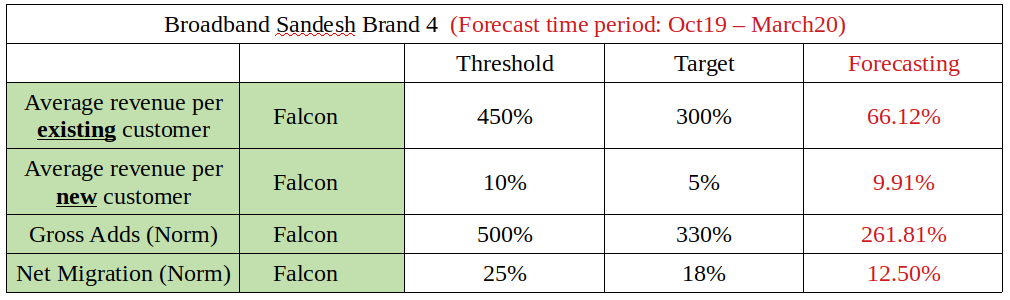

## Robustness Calculation (iteration = 1):  training data (Apr16 - Mar19)

In [46]:
robustness_list

[[1, 'Apr-19', 'Mar-20', 12],
 [2, 'Mar-19', 'Feb-20', 12],
 [3, 'Feb-19', 'Jan-20', 12],
 [4, 'Jan-19', 'Dec-19', 12],
 [5, 'Dec-18', 'Nov-19', 12],
 [6, 'Nov-18', 'Oct-19', 12]]

In [47]:
new_dir = 'robust'
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    print(f"Create {new_dir}/ directory")

In [48]:
regr_var

['Falcon_ARPNU', 'Falcon_ARPEU']

In [49]:
robust_i = 0  # for iteration = 1
iteration = robustness_list[robust_i][0]
start_date = robustness_list[robust_i][1]
end_date = robustness_list[robust_i][2]
forecasting_months = robustness_list[robust_i][3]
print(f"iteration={iteration}, forecasting:({start_date}, {end_date}), forecasting_months={forecasting_months}\n")

# load and pre-process data for iteration = 1
train_i, test_i, _, _ = data_loading(start_date, end_date, forecasting_months, iteration)
train_df = preprocessing(train_i)

regr_df = train_target_regr(train_df, regr_var)
for var in regr_var: # Replace original values by its average with regression results
    train_df[var] = 0.5*train_df[var] + 0.5*regr_df[var]

train_df, train_corr = get_inverse_corr(train_df)
train_df = data_reshape(train_df)
train_df = init_features(train_df, train_corr)
train_month_id_max = np.max(train_df['month_id'])
print(f"iteration={iteration}, train_month_id_max = {train_month_id_max}")
train_df

iteration=1, forecasting:(Apr-19, Mar-20), forecasting_months=12

iteration=1, train_df: start=2016-04-01, end=2019-03-01, #months=36, forecasting_months=12, shape:(18, 37)
iteration=1,  test_df: start=2019-04-01, end=2020-03-01, #months=12, forecasting_months=12, shape:(4, 13)
i=0, target=Falcon_ARPNU   , training feature shape:(36, 17), score=0.699125
i=1, target=Falcon_ARPEU   , training feature shape:(36, 17), score=0.980296
month_dict: 36 {'2016-04-01': 0, '2016-05-01': 1, '2016-06-01': 2, '2016-07-01': 3, '2016-08-01': 4, '2016-09-01': 5, '2016-10-01': 6, '2016-11-01': 7, '2016-12-01': 8, '2017-01-01': 9, '2017-02-01': 10, '2017-03-01': 11, '2017-04-01': 12, '2017-05-01': 13, '2017-06-01': 14, '2017-07-01': 15, '2017-08-01': 16, '2017-09-01': 17, '2017-10-01': 18, '2017-11-01': 19, '2017-12-01': 20, '2018-01-01': 21, '2018-02-01': 22, '2018-03-01': 23, '2018-04-01': 24, '2018-05-01': 25, '2018-06-01': 26, '2018-07-01': 27, '2018-08-01': 28, '2018-09-01': 29, '2018-10-01': 30, '20

,Timestamp,Variable,Z_score,target,month_id,year,month,YYYYMM,Quarter,month_in_Quarter,...,Falcon_Closing_inv,Falcon_Revenue_inv,Falcon_NetAdds_inv,Falcon_Opening_inv,Tortoise_Gross_inv,Falcon_Gross_inv,Tortoise_Migrate_inv,Falcon_Migrate_inv,Tortoise_Leavers_inv,Falcon_Churn_inv
0,2016-04-01,Falcon_ARPEU,-0.740415,-0.740415,0,2016,4,201604,1,1,...,-0.403422,-0.594657,0.517873,-0.416134,0.323633,0.190593,-0.29398,-0.434756,0.541935,-0.505860
1,2016-05-01,Falcon_ARPEU,0.092890,0.092890,1,2016,5,201605,1,2,...,-0.403422,-0.594657,0.517873,-0.416134,0.323633,0.190593,-0.29398,-0.434756,0.541935,-0.505860
2,2016-06-01,Falcon_ARPEU,-0.328077,-0.328077,2,2016,6,201606,1,3,...,-0.403422,-0.594657,0.517873,-0.416134,0.323633,0.190593,-0.29398,-0.434756,0.541935,-0.505860
3,2016-07-01,Falcon_ARPEU,-0.555019,-0.555019,3,2016,7,201607,2,1,...,-0.403422,-0.594657,0.517873,-0.416134,0.323633,0.190593,-0.29398,-0.434756,0.541935,-0.505860
4,2016-08-01,Falcon_ARPEU,-0.587202,-0.587202,4,2016,8,201608,2,2,...,-0.403422,-0.594657,0.517873,-0.416134,0.323633,0.190593,-0.29398,-0.434756,0.541935,-0.505860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,2018-11-01,Tortoise_Revenue_inv,0.577682,0.577682,31,2018,11,201811,3,2,...,-0.916564,-0.922785,0.766254,-0.923002,0.830718,0.035382,0.01187,-0.549081,0.736063,-0.825335
1292,2018-12-01,Tortoise_Revenue_inv,0.572273,0.572273,32,2018,12,201812,3,3,...,-0.916564,-0.922785,0.766254,-0.923002,0.830718,0.035382,0.01187,-0.549081,0.736063,-0.825335
1293,2019-01-01,Tortoise_Revenue_inv,0.654621,0.654621,33,2019,1,201901,4,1,...,-0.916564,-0.922785,0.766254,-0.923002,0.830718,0.035382,0.01187,-0.549081,0.736063,-0.825335
1294,2019-02-01,Tortoise_Revenue_inv,0.708137,0.708137,34,2019,2,201902,4,2,...,-0.916564,-0.922785,0.766254,-0.923002,0.830718,0.035382,0.01187,-0.549081,0.736063,-0.825335


In [50]:
# get training features for iteration = 1
train_features = get_train_features(train_df, forecasting_months)
train_features

generate training features: drop_null_targets = True
month_id=0, initial month_df:(36, 47), forecasting_months=12
month_id=0, historical features=Z_score, max_previous_months=18, month_df.shape=(36, 155)
month_id=0, i=0: add recent(group,mean,std), prev_scale, and prev_norm: (36, 197)

month_id=0, j=0, var_df:(1, 60), month_df_i:(36, 256), merge Tortoise_ARPEU
month_id=0, j=1, var_df:(1, 60), month_df_i:(36, 315), merge Tortoise_ARPNU
month_id=0, j=2, var_df:(1, 60), month_df_i:(36, 374), merge Tortoise_Revenue
month_id=0, j=3, var_df:(1, 60), month_df_i:(36, 433), merge Tortoise_NetAdds
month_id=0, j=4, var_df:(1, 60), month_df_i:(36, 492), merge Tortoise_Opening
month_id=0, j=5, var_df:(1, 60), month_df_i:(36, 551), merge Tortoise_Closing
month_id=0, j=6, var_df:(1, 60), month_df_i:(36, 610), merge Falcon_ARPNU
month_id=0, j=7, var_df:(1, 60), month_df_i:(36, 669), merge Falcon_ARPEU
month_id=0, j=8, var_df:(1, 60), month_df_i:(36, 728), merge Falcon_Closing
month_id=0, j=9, var_df:(

,Timestamp,Variable,Z_score,target,month_id,year,month,YYYYMM,Quarter,month_in_Quarter,...,Z_score_p9N_Falcon_Churn_inv,Z_score_p10N_Falcon_Churn_inv,Z_score_p11N_Falcon_Churn_inv,Z_score_p12N_Falcon_Churn_inv,Z_score_p13N_Falcon_Churn_inv,Z_score_p14N_Falcon_Churn_inv,Z_score_p15N_Falcon_Churn_inv,Z_score_p16N_Falcon_Churn_inv,Z_score_p17N_Falcon_Churn_inv,forecast_n
0,2016-04-01,Falcon_ARPEU,0.833305,-0.740415,1,2016,4,201604,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2016-04-01,Falcon_ARPEU,0.833305,-0.740415,1,2016,4,201604,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2016-04-01,Falcon_ARPEU,0.833305,-0.740415,1,2016,4,201604,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2016-04-01,Falcon_ARPEU,0.833305,-0.740415,1,2016,4,201604,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2016-04-01,Falcon_ARPEU,0.833305,-0.740415,1,2016,4,201604,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229387,2019-02-01,Tortoise_Revenue_inv,0.146101,0.708137,35,2019,2,201902,4,2,...,0.123027,0.331043,0.534259,-0.689836,NaN,NaN,NaN,NaN,NaN,1
229388,2019-02-01,Tortoise_Revenue_inv,0.187527,0.708137,35,2019,2,201902,4,2,...,0.045889,0.252166,0.453683,-0.760179,2.657674,NaN,NaN,NaN,NaN,1
229389,2019-02-01,Tortoise_Revenue_inv,0.241826,0.708137,35,2019,2,201902,4,2,...,0.011666,0.223037,0.429530,-0.814307,2.687949,1.056489,NaN,NaN,NaN,1
229390,2019-02-01,Tortoise_Revenue_inv,0.284902,0.708137,35,2019,2,201902,4,2,...,-0.043126,0.169519,0.377257,-0.874076,2.649285,1.007994,0.478672,NaN,NaN,1


In [51]:
# model_training for iteration = 1
for var_id in range(len(challenge_targets)):
    LGB_training(iteration, var_id) 
    if var_id == 0:
        XGB_training(iteration, var_id)

iteration=1, var_id=0, LightGBM parameter: {'objective': 'regression_l2', 'num_leaves': 8, 'min_data_in_leaf': 20, 'lambda_l1': 0.5, 'max_depth': 6, 'max_bin': 32, 'learning_rate': 0.002, 'boosting': 'gbdt', 'feature_fraction': 0.8, 'bagging_freq': 1, 'bagging_fraction': 0.9, 'bagging_seed': 42, 'metric': 'rmse', 'verbosity': -1, 'thread': 4, 'boost_from_average': False}
iteration=1, var_id=0, target = Falcon_ARPNU, group_min = 0, group_max = 1, month_id_period: (0, -1)
iteration=1, var_id=0, sample weight = [0.        0.4274458 0.5       0.5725542 1.       ]
iteration=1, var_id=0, trn_train.shape=(25488, 2311), num_round=22
[10]	training's rmse: 0.973012
[20]	training's rmse: 0.96514
iteration=1, var_id=0, save model to Falcon_ARPNU_LGB.model

----------------------------------------------------------------------------------------------------

iteration=1, var_id=0, XGBoost parameter: {'objective': 'reg:squarederror', 'tree_method': 'hist', 'min_child_weight': 1, 'eta': 0.02, 'max_bin

In [52]:
# get test features
test_df = preprocessing(test_i)
test_df = data_reshape(test_df)
test_df['month_id'] += train_month_id_max + 1
test_features = get_test_features(train_df, forecasting_months, test_df)
test_features

month_dict: 12 {'2019-04-01': 0, '2019-05-01': 1, '2019-06-01': 2, '2019-07-01': 3, '2019-08-01': 4, '2019-09-01': 5, '2019-10-01': 6, '2019-11-01': 7, '2019-12-01': 8, '2020-01-01': 9, '2020-02-01': 10, '2020-03-01': 11}
generate test_features: drop_null_targets = False
month_id=35, initial month_df:(36, 47), forecasting_months=12
month_id=35, historical features=Z_score, max_previous_months=18, month_df.shape=(36, 155)
month_id=35, i=0: add recent(group,mean,std), prev_scale, and prev_norm: (36, 197)

month_id=35, j=0, var_df:(1, 60), month_df_i:(36, 256), merge Tortoise_ARPEU
month_id=35, j=1, var_df:(1, 60), month_df_i:(36, 315), merge Tortoise_ARPNU
month_id=35, j=2, var_df:(1, 60), month_df_i:(36, 374), merge Tortoise_Revenue
month_id=35, j=3, var_df:(1, 60), month_df_i:(36, 433), merge Tortoise_NetAdds
month_id=35, j=4, var_df:(1, 60), month_df_i:(36, 492), merge Tortoise_Opening
month_id=35, j=5, var_df:(1, 60), month_df_i:(36, 551), merge Tortoise_Closing
month_id=35, j=6, var

,Timestamp,Variable,Z_score,target,month_id,year,month,YYYYMM,Quarter,month_in_Quarter,...,Z_score_p9N_Falcon_Churn_inv,Z_score_p10N_Falcon_Churn_inv,Z_score_p11N_Falcon_Churn_inv,Z_score_p12N_Falcon_Churn_inv,Z_score_p13N_Falcon_Churn_inv,Z_score_p14N_Falcon_Churn_inv,Z_score_p15N_Falcon_Churn_inv,Z_score_p16N_Falcon_Churn_inv,Z_score_p17N_Falcon_Churn_inv,forecast_n
0,2019-04-01,Falcon_ARPEU,-1.355108,1.127399,36,2019,3,201903,4,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2019-04-01,Falcon_ARPEU,-0.910133,1.127399,36,2019,3,201903,4,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2019-04-01,Falcon_ARPEU,-0.669952,1.127399,36,2019,3,201903,4,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2019-04-01,Falcon_ARPEU,-0.660509,1.127399,36,2019,3,201903,4,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,2019-04-01,Falcon_ARPEU,-0.590161,1.127399,36,2019,3,201903,4,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,2020-03-01,Falcon_Migrate,1.925660,1.650920,47,2019,3,201903,4,3,...,1.311612,0.586605,0.838748,1.085071,NaN,NaN,NaN,NaN,NaN,12
860,2020-03-01,Falcon_Migrate,1.923774,1.650920,47,2019,3,201903,4,3,...,0.772703,0.244034,0.427895,0.607512,-0.474435,NaN,NaN,NaN,NaN,12
861,2020-03-01,Falcon_Migrate,1.928475,1.650920,47,2019,3,201903,4,3,...,0.694972,0.170587,0.352957,0.531119,-0.542062,2.479679,NaN,NaN,NaN,12
862,2020-03-01,Falcon_Migrate,1.932773,1.650920,47,2019,3,201903,4,3,...,0.672204,0.136998,0.323132,0.504970,-0.590356,2.493739,1.057072,NaN,NaN,12


In [53]:
# generate_submission
mape_df, sol_df = generate_submission(iteration, test_features)
print(f"iteration={iteration}, mape_df.shape = {mape_df.shape}")
mape_df

LGB: iteration=1, 0, Falcon_ARPNU, tst_test:(24, 2311), null_test:(0, 2311)
LGB: iteration=1, 0, Falcon_ARPNU, #tst_idx=24, validation:(rmse0, rmse1)=(1.739156, 1.739156)
   Timestamp  month_id      Variable    target      pred
0    2019-04        36  Falcon_ARPNU  0.295286  0.307422
1    2019-05        37  Falcon_ARPNU -0.748565  0.307422
2    2019-06        38  Falcon_ARPNU -1.446524  0.307422
3    2019-07        39  Falcon_ARPNU -1.058759  0.307422
4    2019-08        40  Falcon_ARPNU -1.372266  0.307422
5    2019-09        41  Falcon_ARPNU -1.715756  0.307422
6    2019-10        42  Falcon_ARPNU -1.651663  0.304507
7    2019-11        43  Falcon_ARPNU -1.442524  0.304507
8    2019-12        44  Falcon_ARPNU -1.754209  0.304507
9    2020-01        45  Falcon_ARPNU -1.345226  0.304507
10   2020-02        46  Falcon_ARPNU -1.671763  0.304507
11   2020-03        47  Falcon_ARPNU -1.976966  0.304507
LGB: iteration=1, 0, Falcon_ARPNU, #not_null=12, mean_rmse=1.730175, mape=112.412091

XG

,iteration,challenge_targets,MAPE
0,1,Falcon_ARPNU,110.007174
1,1,Falcon_ARPEU,499.352478
2,1,Falcon_Gross,88.782115
3,1,Falcon_Migrate,40.921733


In [54]:
sol_filename = f"{new_dir}/submission{iteration}.csv"
sol_df.to_csv(sol_filename, index=False)
print(f"iteration={iteration}, sol_df.shape = {sol_df.shape}, save to {sol_filename}")
del train_df, test_df; gc.collect()
sol_df

iteration=1, sol_df.shape = (12, 5), save to robust/submission1.csv


,Time Period,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm),Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)
0,2019-04,0.336340,1.210723,-0.046386,0.856833
1,2019-05,0.333405,1.199973,-0.048700,0.856833
2,2019-06,0.331552,1.112562,-0.031952,0.856833
3,2019-07,0.322718,0.915479,-0.016086,0.856833
4,2019-08,0.301604,0.765847,0.039698,0.856833
5,2019-09,0.287322,0.575989,0.091866,0.856833
6,2019-10,0.263935,0.395060,0.122851,0.840772
7,2019-11,0.270230,0.263780,0.157878,0.840772
8,2019-12,0.236581,0.220699,0.161489,0.840772
9,2020-01,0.165836,0.217895,0.177070,0.840772


## Robustness Calculation (iteration = 2): training data (Apr16 - Feb19)

In [55]:
robust_i = 1  # for iteration = 2
iteration = robustness_list[robust_i][0]
start_date = robustness_list[robust_i][1]
end_date = robustness_list[robust_i][2]
forecasting_months = robustness_list[robust_i][3]
print(f"iteration={iteration}, forecasting:({start_date}, {end_date}), forecasting_months={forecasting_months}\n")

# load and pre-process data
train_i, test_i, _, _ = data_loading(start_date, end_date, forecasting_months, iteration)
train_df = preprocessing(train_i)
regr_df = train_target_regr(train_df, regr_var)
for var in regr_var: # Replace original values by its average with regression results
    train_df[var] = 0.5*train_df[var] + 0.5*regr_df[var]
train_df, train_corr = get_inverse_corr(train_df)
train_df = data_reshape(train_df)
train_df = init_features(train_df, train_corr)
train_month_id_max = np.max(train_df['month_id'])
print(f"iteration={iteration}, train_month_id_max = {train_month_id_max}")

# get training features
train_features = get_train_features(train_df, forecasting_months)

# model_training
for var_id in range(len(challenge_targets)):
    LGB_training(iteration, var_id) 
    if var_id == 0:
        XGB_training(iteration, var_id)

# get test features
test_df = preprocessing(test_i)
test_df = data_reshape(test_df)
test_df['month_id'] += train_month_id_max + 1
test_features = get_test_features(train_df, forecasting_months, test_df)

# generate_submission
mape_df, sol_df = generate_submission(iteration, test_features)
print(f"iteration={iteration}, mape_df.shape = {mape_df.shape}")
print(mape_df)

sol_filename = f"{new_dir}/submission{iteration}.csv"
sol_df.to_csv(sol_filename, index=False)
print(f"iteration={iteration}, sol_df.shape = {sol_df.shape}, save to {sol_filename}")
del train_df, test_df; gc.collect()
sol_df

iteration=2, forecasting:(Mar-19, Feb-20), forecasting_months=12

iteration=2, train_df: start=2016-04-01, end=2019-02-01, #months=35, forecasting_months=12, shape:(18, 36)
iteration=2,  test_df: start=2019-03-01, end=2020-02-01, #months=12, forecasting_months=12, shape:(4, 13)
i=0, target=Falcon_ARPNU   , training feature shape:(35, 17), score=0.712699
i=1, target=Falcon_ARPEU   , training feature shape:(35, 17), score=0.974841
month_dict: 35 {'2016-04-01': 0, '2016-05-01': 1, '2016-06-01': 2, '2016-07-01': 3, '2016-08-01': 4, '2016-09-01': 5, '2016-10-01': 6, '2016-11-01': 7, '2016-12-01': 8, '2017-01-01': 9, '2017-02-01': 10, '2017-03-01': 11, '2017-04-01': 12, '2017-05-01': 13, '2017-06-01': 14, '2017-07-01': 15, '2017-08-01': 16, '2017-09-01': 17, '2017-10-01': 18, '2017-11-01': 19, '2017-12-01': 20, '2018-01-01': 21, '2018-02-01': 22, '2018-03-01': 23, '2018-04-01': 24, '2018-05-01': 25, '2018-06-01': 26, '2018-07-01': 27, '2018-08-01': 28, '2018-09-01': 29, '2018-10-01': 30, '20

iteration=2, var_id=0, trn_train.shape=(24624, 2311), num_round=22
[10]	training's rmse: 0.972849
[20]	training's rmse: 0.964819
iteration=2, var_id=0, save model to Falcon_ARPNU_LGB.model

----------------------------------------------------------------------------------------------------

iteration=2, var_id=0, XGBoost parameter: {'objective': 'reg:squarederror', 'tree_method': 'hist', 'min_child_weight': 1, 'eta': 0.02, 'max_bin': 64, 'gamma': 1, 'booster': 'gbtree', 'colsample_bytree': 0.85, 'subsample': 0.9, 'eval_metric': 'rmse', 'lambda': 0.5, 'nthread': 4, 'seed': 2020, 'max_depth': 8}
iteration=2, var_id=0, target = Falcon_ARPNU, group_min = 0, group_max = 17, month_id_period: (22, -1)
iteration=2, var_id=0, sample weight = [0.         0.40829199 0.5        0.59170801 1.        ]
iteration=2, var_id=0, trn_train.shape=(101088, 2311), num_round=253
[0]	train-rmse:1.12900
Will train until train-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.96534
[20]	train-rmse:0.83640
[3

month_id=34, j=26, var_df:(1, 60), month_df_i:(36, 1790), merge Falcon_Closing_inv
month_id=34, j=27, var_df:(1, 60), month_df_i:(36, 1849), merge Falcon_Revenue_inv
month_id=34, j=28, var_df:(1, 60), month_df_i:(36, 1908), merge Falcon_NetAdds_inv
month_id=34, j=29, var_df:(1, 60), month_df_i:(36, 1967), merge Falcon_Opening_inv
month_id=34, j=30, var_df:(1, 60), month_df_i:(36, 2026), merge Tortoise_Gross_inv
month_id=34, j=31, var_df:(1, 60), month_df_i:(36, 2085), merge Falcon_Gross_inv
month_id=34, j=32, var_df:(1, 60), month_df_i:(36, 2144), merge Tortoise_Migrate_inv
month_id=34, j=33, var_df:(1, 60), month_df_i:(36, 2203), merge Falcon_Migrate_inv
month_id=34, j=34, var_df:(1, 60), month_df_i:(36, 2262), merge Tortoise_Leavers_inv
month_id=34, j=35, var_df:(1, 60), month_df_i:(36, 2321), merge Falcon_Churn_inv
month_id=34, rescale i=0: forecasting_months=12, #month_new=12, #data_var=36, #samples=432
month_id=34, rescale i=1: forecasting_months=12, #month_new=24, #data_var=36, #

,Time Period,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm),Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)
0,2019-03,0.863148,1.078660,-0.410503,0.278803
1,2019-04,0.870489,1.073182,-0.414364,0.278803
2,2019-05,0.864610,1.015695,-0.401258,0.278803
3,2019-06,0.812192,0.886033,-0.355543,0.278803
4,2019-07,0.789366,0.809716,-0.262006,0.278803
5,2019-08,0.782807,0.564708,-0.199510,0.278803
6,2019-09,0.781584,0.416177,-0.173920,0.278803
7,2019-10,0.751849,0.348089,-0.164589,0.278803
8,2019-11,0.660402,0.254763,-0.137904,0.278803
9,2019-12,0.446924,0.240567,-0.142482,0.278803


## Robustness Calculation (iteration = 3): training data (Apr16 - Jan19)

In [56]:
robust_i = 2  # for iteration = 3
iteration = robustness_list[robust_i][0]
start_date = robustness_list[robust_i][1]
end_date = robustness_list[robust_i][2]
forecasting_months = robustness_list[robust_i][3]
print(f"iteration={iteration}, forecasting:({start_date}, {end_date}), forecasting_months={forecasting_months}\n")

# load and pre-process data
train_i, test_i, _, _ = data_loading(start_date, end_date, forecasting_months, iteration)
train_df = preprocessing(train_i)
regr_df = train_target_regr(train_df, regr_var)
for var in regr_var: # Replace original values by its average with regression results
    train_df[var] = 0.5*train_df[var] + 0.5*regr_df[var]
train_df, train_corr = get_inverse_corr(train_df)
train_df = data_reshape(train_df)
train_df = init_features(train_df, train_corr)
train_month_id_max = np.max(train_df['month_id'])
print(f"iteration={iteration}, train_month_id_max = {train_month_id_max}")

# get training features
train_features = get_train_features(train_df, forecasting_months)

# model_training
for var_id in range(len(challenge_targets)):
    LGB_training(iteration, var_id) 
    if var_id == 0:
        XGB_training(iteration, var_id)

# get test features
test_df = preprocessing(test_i)
test_df = data_reshape(test_df)
test_df['month_id'] += train_month_id_max + 1
test_features = get_test_features(train_df, forecasting_months, test_df)

# generate_submission
mape_df, sol_df = generate_submission(iteration, test_features)
print(f"iteration={iteration}, mape_df.shape = {mape_df.shape}")
print(mape_df)

sol_filename = f"{new_dir}/submission{iteration}.csv"
sol_df.to_csv(sol_filename, index=False)
print(f"iteration={iteration}, sol_df.shape = {sol_df.shape}, save to {sol_filename}")
del train_df, test_df; gc.collect()
sol_df

iteration=3, forecasting:(Feb-19, Jan-20), forecasting_months=12

iteration=3, train_df: start=2016-04-01, end=2019-01-01, #months=34, forecasting_months=12, shape:(18, 35)
iteration=3,  test_df: start=2019-02-01, end=2020-01-01, #months=12, forecasting_months=12, shape:(4, 13)
i=0, target=Falcon_ARPNU   , training feature shape:(34, 17), score=0.706600
i=1, target=Falcon_ARPEU   , training feature shape:(34, 17), score=0.971723
month_dict: 34 {'2016-04-01': 0, '2016-05-01': 1, '2016-06-01': 2, '2016-07-01': 3, '2016-08-01': 4, '2016-09-01': 5, '2016-10-01': 6, '2016-11-01': 7, '2016-12-01': 8, '2017-01-01': 9, '2017-02-01': 10, '2017-03-01': 11, '2017-04-01': 12, '2017-05-01': 13, '2017-06-01': 14, '2017-07-01': 15, '2017-08-01': 16, '2017-09-01': 17, '2017-10-01': 18, '2017-11-01': 19, '2017-12-01': 20, '2018-01-01': 21, '2018-02-01': 22, '2018-03-01': 23, '2018-04-01': 24, '2018-05-01': 25, '2018-06-01': 26, '2018-07-01': 27, '2018-08-01': 28, '2018-09-01': 29, '2018-10-01': 30, '20

iteration=3, var_id=0, trn_train.shape=(23760, 2311), num_round=22
[10]	training's rmse: 0.97932
[20]	training's rmse: 0.971164
iteration=3, var_id=0, save model to Falcon_ARPNU_LGB.model

----------------------------------------------------------------------------------------------------

iteration=3, var_id=0, XGBoost parameter: {'objective': 'reg:squarederror', 'tree_method': 'hist', 'min_child_weight': 1, 'eta': 0.02, 'max_bin': 64, 'gamma': 1, 'booster': 'gbtree', 'colsample_bytree': 0.85, 'subsample': 0.9, 'eval_metric': 'rmse', 'lambda': 0.5, 'nthread': 4, 'seed': 2020, 'max_depth': 8}
iteration=3, var_id=0, target = Falcon_ARPNU, group_min = 0, group_max = 17, month_id_period: (21, -1)
iteration=3, var_id=0, sample weight = [0.         0.42432096 0.5        0.57567904 1.        ]
iteration=3, var_id=0, trn_train.shape=(101088, 2311), num_round=253
[0]	train-rmse:1.15233
Will train until train-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.98778
[20]	train-rmse:0.85854
[30

month_id=33, j=25, var_df:(1, 60), month_df_i:(36, 1731), merge Falcon_ARPEU_inv
month_id=33, j=26, var_df:(1, 60), month_df_i:(36, 1790), merge Falcon_Closing_inv
month_id=33, j=27, var_df:(1, 60), month_df_i:(36, 1849), merge Falcon_Revenue_inv
month_id=33, j=28, var_df:(1, 60), month_df_i:(36, 1908), merge Falcon_NetAdds_inv
month_id=33, j=29, var_df:(1, 60), month_df_i:(36, 1967), merge Falcon_Opening_inv
month_id=33, j=30, var_df:(1, 60), month_df_i:(36, 2026), merge Tortoise_Gross_inv
month_id=33, j=31, var_df:(1, 60), month_df_i:(36, 2085), merge Falcon_Gross_inv
month_id=33, j=32, var_df:(1, 60), month_df_i:(36, 2144), merge Tortoise_Migrate_inv
month_id=33, j=33, var_df:(1, 60), month_df_i:(36, 2203), merge Falcon_Migrate_inv
month_id=33, j=34, var_df:(1, 60), month_df_i:(36, 2262), merge Tortoise_Leavers_inv
month_id=33, j=35, var_df:(1, 60), month_df_i:(36, 2321), merge Falcon_Churn_inv
month_id=33, rescale i=0: forecasting_months=12, #month_new=12, #data_var=36, #samples=43

,Time Period,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm),Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)
0,2019-02,0.421874,0.927669,-0.876120,-0.050989
1,2019-03,0.413815,0.919159,-0.876120,-0.050989
2,2019-04,0.374642,0.873458,-0.856364,-0.050989
3,2019-05,0.351988,0.810350,-0.814643,-0.050989
4,2019-06,0.343811,0.680774,-0.682228,-0.050989
5,2019-07,0.315288,0.429509,-0.599654,-0.050989
6,2019-08,0.296114,0.358765,-0.549918,-0.050989
7,2019-09,0.277523,0.303187,-0.541444,-0.050989
8,2019-10,0.255466,0.191444,-0.521597,-0.050989
9,2019-11,0.213665,0.191444,-0.521332,-0.050989


## Robustness Calculation (iteration = 4): training data (Apr16 - Dec18)

In [57]:
robust_i = 3  # for iteration = 4
iteration = robustness_list[robust_i][0]
start_date = robustness_list[robust_i][1]
end_date = robustness_list[robust_i][2]
forecasting_months = robustness_list[robust_i][3]
print(f"iteration={iteration}, forecasting:({start_date}, {end_date}), forecasting_months={forecasting_months}\n")

# load and pre-process data
train_i, test_i, _, _ = data_loading(start_date, end_date, forecasting_months, iteration)
train_df = preprocessing(train_i)
regr_df = train_target_regr(train_df, regr_var)
for var in regr_var: # Replace original values by its average with regression results
    train_df[var] = 0.5*train_df[var] + 0.5*regr_df[var]
train_df, train_corr = get_inverse_corr(train_df)
train_df = data_reshape(train_df)
train_df = init_features(train_df, train_corr)
train_month_id_max = np.max(train_df['month_id'])
print(f"iteration={iteration}, train_month_id_max = {train_month_id_max}")

# get training features
train_features = get_train_features(train_df, forecasting_months)

# model_training
for var_id in range(len(challenge_targets)):
    LGB_training(iteration, var_id) 
    if var_id == 0:
        XGB_training(iteration, var_id) 

# get test features
test_df = preprocessing(test_i)
test_df = data_reshape(test_df)
test_df['month_id'] += train_month_id_max + 1
test_features = get_test_features(train_df, forecasting_months, test_df)

# generate_submission
mape_df, sol_df = generate_submission(iteration, test_features)
print(f"iteration={iteration}, mape_df.shape = {mape_df.shape}")
print(mape_df)

sol_filename = f"{new_dir}/submission{iteration}.csv"
sol_df.to_csv(sol_filename, index=False)
print(f"iteration={iteration}, sol_df.shape = {sol_df.shape}, save to {sol_filename}")
del train_df, test_df; gc.collect()
sol_df

iteration=4, forecasting:(Jan-19, Dec-19), forecasting_months=12

iteration=4, train_df: start=2016-04-01, end=2018-12-01, #months=33, forecasting_months=12, shape:(18, 34)
iteration=4,  test_df: start=2019-01-01, end=2019-12-01, #months=12, forecasting_months=12, shape:(4, 13)
i=0, target=Falcon_ARPNU   , training feature shape:(33, 17), score=0.703985
i=1, target=Falcon_ARPEU   , training feature shape:(33, 17), score=0.969339
month_dict: 33 {'2016-04-01': 0, '2016-05-01': 1, '2016-06-01': 2, '2016-07-01': 3, '2016-08-01': 4, '2016-09-01': 5, '2016-10-01': 6, '2016-11-01': 7, '2016-12-01': 8, '2017-01-01': 9, '2017-02-01': 10, '2017-03-01': 11, '2017-04-01': 12, '2017-05-01': 13, '2017-06-01': 14, '2017-07-01': 15, '2017-08-01': 16, '2017-09-01': 17, '2017-10-01': 18, '2017-11-01': 19, '2017-12-01': 20, '2018-01-01': 21, '2018-02-01': 22, '2018-03-01': 23, '2018-04-01': 24, '2018-05-01': 25, '2018-06-01': 26, '2018-07-01': 27, '2018-08-01': 28, '2018-09-01': 29, '2018-10-01': 30, '20

iteration=4, var_id=0, trn_train.shape=(22896, 2311), num_round=22
[10]	training's rmse: 0.985262
[20]	training's rmse: 0.976998
iteration=4, var_id=0, save model to Falcon_ARPNU_LGB.model

----------------------------------------------------------------------------------------------------

iteration=4, var_id=0, XGBoost parameter: {'objective': 'reg:squarederror', 'tree_method': 'hist', 'min_child_weight': 1, 'eta': 0.02, 'max_bin': 64, 'gamma': 1, 'booster': 'gbtree', 'colsample_bytree': 0.85, 'subsample': 0.9, 'eval_metric': 'rmse', 'lambda': 0.5, 'nthread': 4, 'seed': 2020, 'max_depth': 8}
iteration=4, var_id=0, target = Falcon_ARPNU, group_min = 0, group_max = 17, month_id_period: (20, -1)
iteration=4, var_id=0, sample weight = [0.         0.43158567 0.5        0.56841433 1.        ]
iteration=4, var_id=0, trn_train.shape=(101088, 2311), num_round=253
[0]	train-rmse:1.14976
Will train until train-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.98590
[20]	train-rmse:0.85728
[3

month_id=32, j=25, var_df:(1, 60), month_df_i:(36, 1731), merge Falcon_ARPEU_inv
month_id=32, j=26, var_df:(1, 60), month_df_i:(36, 1790), merge Falcon_Closing_inv
month_id=32, j=27, var_df:(1, 60), month_df_i:(36, 1849), merge Falcon_Revenue_inv
month_id=32, j=28, var_df:(1, 60), month_df_i:(36, 1908), merge Falcon_NetAdds_inv
month_id=32, j=29, var_df:(1, 60), month_df_i:(36, 1967), merge Falcon_Opening_inv
month_id=32, j=30, var_df:(1, 60), month_df_i:(36, 2026), merge Tortoise_Gross_inv
month_id=32, j=31, var_df:(1, 60), month_df_i:(36, 2085), merge Falcon_Gross_inv
month_id=32, j=32, var_df:(1, 60), month_df_i:(36, 2144), merge Tortoise_Migrate_inv
month_id=32, j=33, var_df:(1, 60), month_df_i:(36, 2203), merge Falcon_Migrate_inv
month_id=32, j=34, var_df:(1, 60), month_df_i:(36, 2262), merge Tortoise_Leavers_inv
month_id=32, j=35, var_df:(1, 60), month_df_i:(36, 2321), merge Falcon_Churn_inv
month_id=32, rescale i=0: forecasting_months=12, #month_new=12, #data_var=36, #samples=43

,Time Period,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm),Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)
0,2019-01,-0.203599,0.815155,-0.678140,-0.237074
1,2019-02,-0.206528,0.801140,-0.672717,-0.237074
2,2019-03,-0.219875,0.762231,-0.651421,-0.237074
3,2019-04,-0.242382,0.711013,-0.625250,-0.237074
4,2019-05,-0.265043,0.592402,-0.560628,-0.237074
5,2019-06,-0.279908,0.383106,-0.488082,-0.234274
6,2019-07,-0.301733,0.363948,-0.449850,-0.234274
7,2019-08,-0.343356,0.283303,-0.420868,-0.234274
8,2019-09,-0.337196,0.203144,-0.421249,-0.234274
9,2019-10,-0.298860,0.201710,-0.399816,-0.234274


## Robustness Calculation (iteration = 5): training data (Apr16 - Nov18)

In [58]:
robust_i = 4  # for iteration = 5
iteration = robustness_list[robust_i][0]
start_date = robustness_list[robust_i][1]
end_date = robustness_list[robust_i][2]
forecasting_months = robustness_list[robust_i][3]
print(f"iteration={iteration}, forecasting:({start_date}, {end_date}), forecasting_months={forecasting_months}\n")

# load and pre-process data
train_i, test_i, _, _ = data_loading(start_date, end_date, forecasting_months, iteration)
train_df = preprocessing(train_i)
regr_df = train_target_regr(train_df, regr_var)
for var in regr_var: # Replace original values by its average with regression results
    train_df[var] = 0.5*train_df[var] + 0.5*regr_df[var]
train_df, train_corr = get_inverse_corr(train_df)
train_df = data_reshape(train_df)
train_df = init_features(train_df, train_corr)
train_month_id_max = np.max(train_df['month_id'])
print(f"iteration={iteration}, train_month_id_max = {train_month_id_max}")

# get training features
train_features = get_train_features(train_df, forecasting_months)

# model_training
for var_id in range(len(challenge_targets)):
    LGB_training(iteration, var_id) 
    if var_id == 0:
        XGB_training(iteration, var_id)

# get test features
test_df = preprocessing(test_i)
test_df = data_reshape(test_df)
test_df['month_id'] += train_month_id_max + 1
test_features = get_test_features(train_df, forecasting_months, test_df)

# generate_submission
mape_df, sol_df = generate_submission(iteration, test_features)
print(f"iteration={iteration}, mape_df.shape = {mape_df.shape}")
print(mape_df)

sol_filename = f"{new_dir}/submission{iteration}.csv"
sol_df.to_csv(sol_filename, index=False)
print(f"iteration={iteration}, sol_df.shape = {sol_df.shape}, save to {sol_filename}")
del train_df, test_df; gc.collect()
sol_df

iteration=5, forecasting:(Dec-18, Nov-19), forecasting_months=12

iteration=5, train_df: start=2016-04-01, end=2018-11-01, #months=32, forecasting_months=12, shape:(18, 33)
iteration=5,  test_df: start=2018-12-01, end=2019-11-01, #months=12, forecasting_months=12, shape:(4, 13)
i=0, target=Falcon_ARPNU   , training feature shape:(32, 17), score=0.706902
i=1, target=Falcon_ARPEU   , training feature shape:(32, 17), score=0.963862
month_dict: 32 {'2016-04-01': 0, '2016-05-01': 1, '2016-06-01': 2, '2016-07-01': 3, '2016-08-01': 4, '2016-09-01': 5, '2016-10-01': 6, '2016-11-01': 7, '2016-12-01': 8, '2017-01-01': 9, '2017-02-01': 10, '2017-03-01': 11, '2017-04-01': 12, '2017-05-01': 13, '2017-06-01': 14, '2017-07-01': 15, '2017-08-01': 16, '2017-09-01': 17, '2017-10-01': 18, '2017-11-01': 19, '2017-12-01': 20, '2018-01-01': 21, '2018-02-01': 22, '2018-03-01': 23, '2018-04-01': 24, '2018-05-01': 25, '2018-06-01': 26, '2018-07-01': 27, '2018-08-01': 28, '2018-09-01': 29, '2018-10-01': 30, '20

iteration=5, var_id=0, trn_train.shape=(22032, 2311), num_round=22
[10]	training's rmse: 0.986838
[20]	training's rmse: 0.978472
iteration=5, var_id=0, save model to Falcon_ARPNU_LGB.model

----------------------------------------------------------------------------------------------------

iteration=5, var_id=0, XGBoost parameter: {'objective': 'reg:squarederror', 'tree_method': 'hist', 'min_child_weight': 1, 'eta': 0.02, 'max_bin': 64, 'gamma': 1, 'booster': 'gbtree', 'colsample_bytree': 0.85, 'subsample': 0.9, 'eval_metric': 'rmse', 'lambda': 0.5, 'nthread': 4, 'seed': 2020, 'max_depth': 8}
iteration=5, var_id=0, target = Falcon_ARPNU, group_min = 0, group_max = 17, month_id_period: (19, -1)
iteration=5, var_id=0, sample weight = [0.         0.41606923 0.5        0.58393077 1.        ]
iteration=5, var_id=0, trn_train.shape=(101088, 2311), num_round=253
[0]	train-rmse:1.11867
Will train until train-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.96178
[20]	train-rmse:0.83890
[3

month_id=31, j=27, var_df:(1, 60), month_df_i:(36, 1849), merge Falcon_Revenue_inv
month_id=31, j=28, var_df:(1, 60), month_df_i:(36, 1908), merge Falcon_NetAdds_inv
month_id=31, j=29, var_df:(1, 60), month_df_i:(36, 1967), merge Falcon_Opening_inv
month_id=31, j=30, var_df:(1, 60), month_df_i:(36, 2026), merge Tortoise_Gross_inv
month_id=31, j=31, var_df:(1, 60), month_df_i:(36, 2085), merge Falcon_Gross_inv
month_id=31, j=32, var_df:(1, 60), month_df_i:(36, 2144), merge Tortoise_Migrate_inv
month_id=31, j=33, var_df:(1, 60), month_df_i:(36, 2203), merge Falcon_Migrate_inv
month_id=31, j=34, var_df:(1, 60), month_df_i:(36, 2262), merge Tortoise_Leavers_inv
month_id=31, j=35, var_df:(1, 60), month_df_i:(36, 2321), merge Falcon_Churn_inv
month_id=31, rescale i=0: forecasting_months=12, #month_new=12, #data_var=36, #samples=432
month_id=31, rescale i=1: forecasting_months=12, #month_new=24, #data_var=36, #samples=864
month_id=31, rescale i=2: forecasting_months=12, #month_new=36, #data_v

,Time Period,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm),Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)
0,2018-12,0.136601,0.815340,-0.259226,0.000576
1,2019-01,0.134299,0.821221,-0.252372,0.000576
2,2019-02,0.120761,0.794849,-0.232989,0.000576
3,2019-03,0.093816,0.720843,-0.206307,0.000576
4,2019-04,0.052544,0.650770,-0.166594,0.000576
5,2019-05,0.015445,0.527220,-0.127920,0.000576
6,2019-06,-0.005069,0.448851,-0.111936,0.000576
7,2019-07,-0.007401,0.397827,-0.114480,0.000576
8,2019-08,-0.022095,0.298558,-0.099569,0.000576
9,2019-09,-0.043569,0.293451,-0.100837,0.000576


## Robustness Calculation (iteration = 6): training data (Apr16 - Oct18)

In [59]:
robust_i = 5  # for iteration = 6
iteration = robustness_list[robust_i][0]
start_date = robustness_list[robust_i][1]
end_date = robustness_list[robust_i][2]
forecasting_months = robustness_list[robust_i][3]
print(f"iteration={iteration}, forecasting:({start_date}, {end_date}), forecasting_months={forecasting_months}\n")

# load and pre-process data
train_i, test_i, _, _ = data_loading(start_date, end_date, forecasting_months, iteration)
train_df = preprocessing(train_i)
regr_df = train_target_regr(train_df, regr_var)
for var in regr_var: # Replace original values by its average with regression results
    train_df[var] = 0.5*train_df[var] + 0.5*regr_df[var]
train_df, train_corr = get_inverse_corr(train_df)
train_df = data_reshape(train_df)
train_df = init_features(train_df, train_corr)
train_month_id_max = np.max(train_df['month_id'])
print(f"iteration={iteration}, train_month_id_max = {train_month_id_max}")

# get training features
train_features = get_train_features(train_df, forecasting_months)

# model_training
for var_id in range(len(challenge_targets)):
    LGB_training(iteration, var_id) 
    if var_id == 0:
        XGB_training(iteration, var_id)

# get test features
test_df = preprocessing(test_i)
test_df = data_reshape(test_df)
test_df['month_id'] += train_month_id_max + 1
test_features = get_test_features(train_df, forecasting_months, test_df)

# generate_submission
mape_df, sol_df = generate_submission(iteration, test_features)
print(f"iteration={iteration}, mape_df.shape = {mape_df.shape}")
print(mape_df)

sol_filename = f"{new_dir}/submission{iteration}.csv"
sol_df.to_csv(sol_filename, index=False)
print(f"iteration={iteration}, sol_df.shape = {sol_df.shape}, save to {sol_filename}")
del train_df, test_df; gc.collect()
sol_df

iteration=6, forecasting:(Nov-18, Oct-19), forecasting_months=12

iteration=6, train_df: start=2016-04-01, end=2018-10-01, #months=31, forecasting_months=12, shape:(18, 32)
iteration=6,  test_df: start=2018-11-01, end=2019-10-01, #months=12, forecasting_months=12, shape:(4, 13)
i=0, target=Falcon_ARPNU   , training feature shape:(31, 17), score=0.711873
i=1, target=Falcon_ARPEU   , training feature shape:(31, 17), score=0.954100
month_dict: 31 {'2016-04-01': 0, '2016-05-01': 1, '2016-06-01': 2, '2016-07-01': 3, '2016-08-01': 4, '2016-09-01': 5, '2016-10-01': 6, '2016-11-01': 7, '2016-12-01': 8, '2017-01-01': 9, '2017-02-01': 10, '2017-03-01': 11, '2017-04-01': 12, '2017-05-01': 13, '2017-06-01': 14, '2017-07-01': 15, '2017-08-01': 16, '2017-09-01': 17, '2017-10-01': 18, '2017-11-01': 19, '2017-12-01': 20, '2018-01-01': 21, '2018-02-01': 22, '2018-03-01': 23, '2018-04-01': 24, '2018-05-01': 25, '2018-06-01': 26, '2018-07-01': 27, '2018-08-01': 28, '2018-09-01': 29, '2018-10-01': 30}
ite

iteration=6, var_id=0, trn_train.shape=(21168, 2311), num_round=22
[10]	training's rmse: 0.993317
[20]	training's rmse: 0.984893
iteration=6, var_id=0, save model to Falcon_ARPNU_LGB.model

----------------------------------------------------------------------------------------------------

iteration=6, var_id=0, XGBoost parameter: {'objective': 'reg:squarederror', 'tree_method': 'hist', 'min_child_weight': 1, 'eta': 0.02, 'max_bin': 64, 'gamma': 1, 'booster': 'gbtree', 'colsample_bytree': 0.85, 'subsample': 0.9, 'eval_metric': 'rmse', 'lambda': 0.5, 'nthread': 4, 'seed': 2020, 'max_depth': 8}
iteration=6, var_id=0, target = Falcon_ARPNU, group_min = 0, group_max = 17, month_id_period: (18, -1)
iteration=6, var_id=0, sample weight = [0.         0.41081205 0.5        0.58918795 1.        ]
iteration=6, var_id=0, trn_train.shape=(101088, 2311), num_round=253
[0]	train-rmse:1.11962
Will train until train-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.96539
[20]	train-rmse:0.84290
[3

month_id=30, j=25, var_df:(1, 60), month_df_i:(36, 1731), merge Falcon_ARPEU_inv
month_id=30, j=26, var_df:(1, 60), month_df_i:(36, 1790), merge Falcon_Closing_inv
month_id=30, j=27, var_df:(1, 60), month_df_i:(36, 1849), merge Falcon_Revenue_inv
month_id=30, j=28, var_df:(1, 60), month_df_i:(36, 1908), merge Falcon_NetAdds_inv
month_id=30, j=29, var_df:(1, 60), month_df_i:(36, 1967), merge Falcon_Opening_inv
month_id=30, j=30, var_df:(1, 60), month_df_i:(36, 2026), merge Tortoise_Gross_inv
month_id=30, j=31, var_df:(1, 60), month_df_i:(36, 2085), merge Falcon_Gross_inv
month_id=30, j=32, var_df:(1, 60), month_df_i:(36, 2144), merge Tortoise_Migrate_inv
month_id=30, j=33, var_df:(1, 60), month_df_i:(36, 2203), merge Falcon_Migrate_inv
month_id=30, j=34, var_df:(1, 60), month_df_i:(36, 2262), merge Tortoise_Leavers_inv
month_id=30, j=35, var_df:(1, 60), month_df_i:(36, 2321), merge Falcon_Churn_inv
month_id=30, rescale i=0: forecasting_months=12, #month_new=12, #data_var=36, #samples=43

,Time Period,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon,Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm),Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)
0,2018-11,0.250462,0.436726,-0.430150,-0.141986
1,2018-12,0.248267,0.443835,-0.421410,-0.141986
2,2019-01,0.226292,0.421539,-0.401246,-0.141986
3,2019-02,0.202186,0.378225,-0.368459,-0.141986
4,2019-03,0.200079,0.347490,-0.339630,-0.141986
5,2019-04,0.160945,0.236093,-0.301376,-0.141986
6,2019-05,0.145758,0.145836,-0.193058,-0.141986
7,2019-06,0.117115,0.111554,-0.170851,-0.141986
8,2019-07,0.120525,0.097291,-0.159330,-0.141986
9,2019-08,0.101195,0.095748,-0.147298,-0.141986


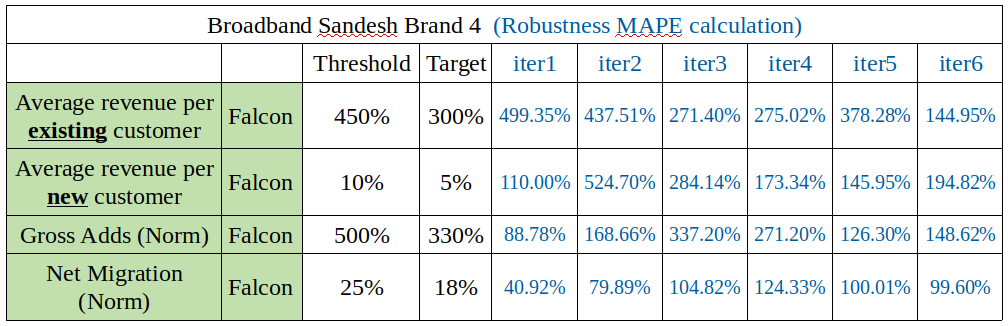